# 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import talib
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import yfinance as yf

from IPython.display import clear_output

%matplotlib inline

pd.set_option('display.max_columns', None)

In [3]:
# Загрузим 15-минутные данные по ETH
eth_df = yf.download("ETH-USD", start='2024-11-30', end='2025-01-28', interval='15m', multi_level_index=False).drop('Adj Close', axis=1)
eth_df

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2024-11-30 00:00:00,3586.687012,3593.657959,3586.687012,3593.657959,0
2024-11-30 00:15:00,3610.290771,3610.290771,3586.640381,3588.070801,42741760
2024-11-30 00:30:00,3586.115967,3607.749268,3586.115967,3607.749268,107397120
2024-11-30 00:45:00,3594.481201,3595.041992,3582.804199,3582.804199,75782144
2024-11-30 01:00:00,3583.166992,3592.524902,3574.100586,3592.524902,19570688
...,...,...,...,...,...
2025-01-27 22:45:00,3173.094971,3179.078125,3169.643799,3169.643799,63287296
2025-01-27 23:00:00,3174.085205,3176.448730,3173.254150,3176.448730,374640640
2025-01-27 23:15:00,3161.831055,3173.617920,3161.831055,3173.617920,0


In [4]:
eth_df.to_csv('eth_15m.csv')

In [ ]:
# Загрузим из файла
# eth_df = pd.read_csv('eth_15m.csv', index_col=0, parse_dates=True)
# eth_df

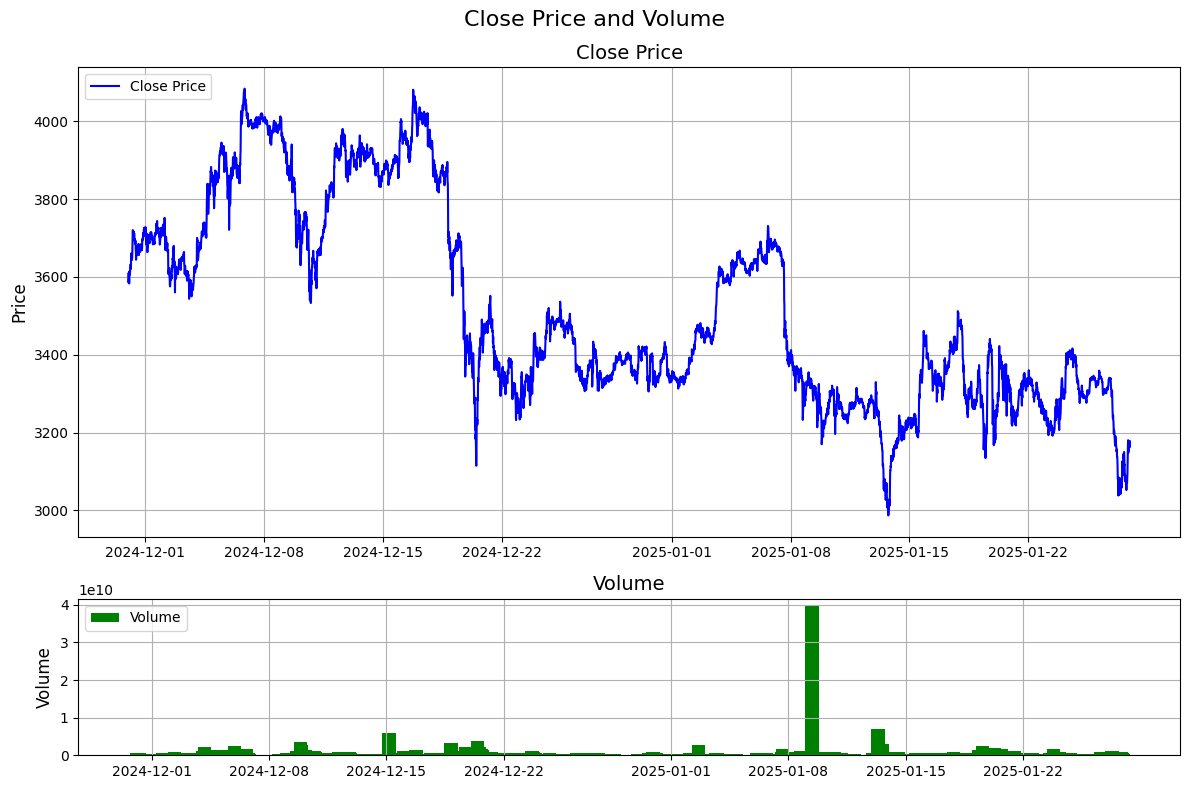

In [4]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(
    2, 1,  # 2 строки, 1 столбец
    figsize=(12, 8),  # Размер фигуры
    gridspec_kw={'height_ratios': [3, 1]}
)

# График Close (цена)
ax1.plot(eth_df.index, eth_df['Close'], label='Close Price', color='blue')
ax1.set_title('Close Price', fontsize=14)
ax1.set_ylabel('Price', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True)

# График Volume (объем)
ax2.bar(eth_df.index, eth_df['Volume'], label='Volume', color='green')
ax2.set_title('Volume', fontsize=14)
ax2.set_ylabel('Volume', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True)

# Настройка общего заголовка
plt.suptitle('Close Price and Volume', fontsize=16)

# Отображение графиков
plt.tight_layout()
plt.show()

# 2. Подготовка данных

In [5]:
def fill_missing_values(data):
    """
    Функция заполняет пропущенные значения в DataFrame предыдущими значениями 
    и удаляет дубликаты по индексу.
    """
    df = data.copy()

    # Проверка и удаление дубликатов по индексу
    if df.index.duplicated().any():
        print("Обнаружены дубликаты по индексу. Они будут удалены.")
        df = df[~df.index.duplicated(keep='first')]
    else:
        print("Дубликатов не обнаружено.")

    # Проверка на наличие пропущенных значений
    if df.isnull().any().any():
        print("Обнаружены пропущенные значения. Выполняется заполнение предыдущими значениями...")
        # Заполняем пропущенные значения предыдущими
        df = df.fillna(method='ffill')
        
        # Если в начале есть NaN, заполняем их последующими значениями
        df = df.fillna(method='bfill')
    else:
        print("Пропущенные значения отсутствуют.")

    return df

In [6]:
# Функция для добавления лагов

def add_lags(data, columns, lags):
    """Функция для добавления лагов

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета лагов
        lags (List): список шагов назад для расчета лагов
    """
    df = data.copy()

    for lag in lags: # Добавляем лаги по шагам назад из lags
        for column in columns:
            new_col_name = f'{column}_lag_{lag}'
            df[new_col_name] = df[column].shift(lag)
    
    return df

In [7]:
# Функция для добавления индикаторов

def add_indicators(data, columns, windows_SMA, windows_RSI):
    """Функция для добавления индикаторов SMA и RSI

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета индикаторов
        windows_SMA (List): список окон для расчета MA
        windows_RSI (List): список окон для расчета RSI
    """
    df = data.copy()

    for window in windows_SMA: # Расчитываем и добавляем SMA по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_SMA_{window}'
            df[new_col_name] = df[column].rolling(window).mean()

    for window in windows_RSI: # Расчитываем и добавляем RSI по указанным колонкам
        for column in columns:
            new_col_name = f'{column}_RSI_{window}'
            df[new_col_name] = talib.RSI(df[column], timeperiod=window)
    
    return df

In [8]:
# Функция для добавления статистик

def add_stats_features(data, columns, windows):
    """Функция для добавления статистик, min, max, std за периоды windows

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк для расчета статистик
        windows (List): список окон для расчета статистик
    """   
    df = data.copy()

    for column in columns:
        for window in windows:
            # Скользящее среднее
            df[f'{column}_mean_{window}'] = df[column].rolling(window=window).mean()
            
            # Скользящая медиана
            df[f'{column}_median_{window}'] = df[column].rolling(window=window).median()
            
            # Скользящий минимум
            df[f'{column}_min_{window}'] = df[column].rolling(window=window).min()
            
            # Скользящий максимум
            df[f'{column}_max_{window}'] = df[column].rolling(window=window).max()
            
            # Скользящее стандартное отклонение
            df[f'{column}_std_{window}'] = df[column].rolling(window=window).std()
            
            # Скользящий размах (макс - мин)
            df[f'{column}_range_{window}'] = df[f'{column}_max_{window}'] - df[f'{column}_min_{window}']

    return df

In [9]:
# Функция для добавления разницы между higt и low

def add_hight_low_dif(data):
    df = data.copy()
    df['High-Low'] = df['High'] - df['Low']
    return df

In [10]:
# Функция для добавления трендовых фичей

def add_trend_feat(data, columns, windows):
    """Функция для трендовых фичей

    Args:
        data (pd.Dataframe): pandas Dataframe с данными по активу
        columns (List): список колонорк трендовых фичей
        windows (List): список окон трендовых фичей
    """   
    df = data.copy()
    for column in columns:
        for window in windows:
            # Отношение текущего значения к предыдущему (лаг = 1)
            df[f'{column}_ratio_1'] = df[column] / df[column].shift(1)
            
            # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
            df[f'{column}_log_diff_1'] = np.log(df[column] / df[column].shift(1))
            
            # Momentum (разница между текущим значением и значением N периодов назад)
            df[f'{column}_momentum_{window}'] = df[column] - df[column].shift(window)
            
            # Rate of Change (ROC): процентное изменение за N периодов
            df[f'{column}_roc_{window}'] = (df[column] - df[column].shift(window)) / df[column].shift(window) * 100
    
    return df    

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle

# Функция для нормализации данных

def normalize_dataframe(data, scaler="StandardScaler", save_scaler=True, scaler_file="scaler.pkl"):
    """Функция нормализует DataFrame с использованием заданного скейлера.

    Args:
    df (pd.DataFrame): Датафрейм для нормализации.
    scaler (str or sklearn Scaler): Имя скейлера ("StandardScaler", "MinMaxScaler", "RobustScaler") 
                                     или уже обученный объект скейлера.
    save_scaler (bool): сохранять ли scaler в файл (по умолчанию: сохранять)
    scaler_file (str): Имя файла, куда сохраняется обученный скейлер (по умолчанию: "scaler.pkl").

    """
    df = data.copy()

    if isinstance(scaler, str):
        # Создаем скейлер на основе переданного имени
        if scaler == "StandardScaler":
            scaler = StandardScaler()
        elif scaler == "MinMaxScaler":
            scaler = MinMaxScaler()
        elif scaler == "RobustScaler":
            scaler = RobustScaler()
        else:
            raise ValueError(f"Неизвестный скейлер: {scaler}")

        # Обучаем скейлер на датафрейме
        scaler.fit(df)

        # Сохраняем обученный скейлер в файл
        if save_scaler:
            with open(scaler_file, "wb") as f:
                pickle.dump(scaler, f)
    elif hasattr(scaler, "transform"):
        # Если передан обученный скейлер, просто используем его
        pass
    else:
        raise ValueError("Передан некорректный скейлер. Должна быть строка 'StandardScaler', 'MinMaxScaler', 'RobustScaler' или объект sklearn Scaler.")

    # Применяем скейлер к датафрейму
    normalized_data = scaler.transform(df)

    # Возвращаем нормализованный датафрейм и обученный скейлер
    return pd.DataFrame(normalized_data, columns=df.columns, index=df.index), scaler

In [13]:
# Функция для загрузки скейлера из файла
def load_scaler(scaler_file):
    """Загружает скейлер из указанного файла.

    Args:
    scaler_file (str): Путь к файлу, содержащему сохранённый скейлер.

    Return:
    sklearn Scaler: Загруженный объект скейлера.
    """
    with open(scaler_file, "rb") as f:
        scaler = pickle.load(f)
    return scaler

In [14]:
# Функция для добавления номеров месяцев, дней, часов

def add_datetime_features(data, add_month=True, add_weekday=True, add_hour=True):
    """Функция добавляет в DataFrame столбцы с номером месяца, дня недели и часа из индекса Datetime.
    
    Args:
    df (pd.DataFrame): DataFrame с индексом типа Datetime.
    add_month (bool): Добавлять ли столбец с номером месяца (1-12).
    add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
    add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """
    df = data.copy()
    
    # Добавляем столбцы по выбору
    if add_month:
        df['Month'] = df.index.month
    if add_weekday:
        df['Weekday'] = df.index.weekday
    if add_hour:
        df['Hour'] = df.index.hour
    
    return df

In [15]:
def prepare_date(data, 
                 lags, 
                 windows_SMA, 
                 windows_RSI, 
                 windows_stats, 
                 windows_trend, 
                 add_month=True, 
                 add_weekday=True, 
                 add_hour=True):
    """
    Функция для добавления фичей и нормализации

    Args:
        data (pd.DataFrame): DataFrame с индексом типа Datetime.
        windows_SMA (List): список окон для индикатора SMA.
        windows_RSI (List): список окон для индикатора RSI.
        windows_stats (List): список окон для статистических фичей.
        windows_trend (List): список окон для трендовых фичей.
        add_month (bool): Добавлять ли столбец с номером месяца (1-12).
        add_weekday (bool): Добавлять ли столбец с номером дня недели (0 - понедельник, 6 - воскресенье).
        add_hour (bool): Добавлять ли столбец с номером часа (0-23).
    """

    df = data.copy()
    columns = df.columns

    df = fill_missing_values(df)
    df = add_lags(df, columns=columns, lags=lags)
    df = add_indicators(df, columns=['Close'], windows_SMA=windows_SMA, windows_RSI=windows_RSI)
    df = add_stats_features(df, columns=['Close'], windows=windows_stats)
    df = add_hight_low_dif(df)
    df = add_trend_feat(df, columns=['Close'], windows=windows_trend)
    df = add_datetime_features(df, add_month=add_month, add_weekday=add_weekday, add_hour=add_hour)
    df = df.dropna()

    return df

In [16]:
eth_df.describe()

,Close,High,Low,Open,Volume
count,5657.000000,5657.000000,5657.000000,5657.000000,5.657000e+03
mean,3516.162973,3522.529734,3509.614664,3516.201000,1.650969e+08
std,256.018110,255.908990,256.234447,256.063689,6.008926e+08
min,2986.886230,3011.861328,2920.592773,2986.638184,0.000000e+00
25%,3319.969727,3326.691406,3312.917969,3319.756104,0.000000e+00
50%,3414.162109,3420.514893,3407.502686,3414.366699,4.622746e+07
75%,3700.130371,3706.196777,3692.436768,3699.854736,2.135572e+08
max,4083.794189,4104.651367,4083.307373,4087.850098,3.963021e+10


In [17]:
eth_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5657 entries, 2024-11-30 00:00:00 to 2025-01-27 23:45:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5657 non-null   float64
 1   High    5657 non-null   float64
 2   Low     5657 non-null   float64
 3   Open    5657 non-null   float64
 4   Volume  5657 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 265.2 KB


In [18]:
window_lag = [3, 9, 15, 30]
window_SMA = [6, 9, 30, 50]
window_RSI = [4, 9, 20]
windows_stats = [3, 10, 30, 50]
windows_trend = [3, 10, 30, 50]

In [19]:
eth_df_features = prepare_date(eth_df, lags=window_lag, windows_SMA=window_SMA, windows_RSI=window_RSI, windows_stats=windows_stats, windows_trend=windows_trend)

Дубликатов не обнаружено.
Пропущенные значения отсутствуют.


In [20]:
eth_df_features.shape

(5607, 70)

Идея: Попробовать обучить модель предсказывать сильные движения цены. Целевая метка - изменение цены через час. Будем отслеживать рост или снижение цены более чем заданное процентное изменение.

In [21]:
def add_target_column(df, close_col='Close', threshold=1):
    """
    Добавляет колонку target в датафрейм на основе процентного изменения цены через час.

    - df: Исходный датафрейм.
    - close_col: Название колонки с ценами закрытия.
    - threshold: Пороговое значение процента для классификации.
    """
    # Рассчитываем процентное изменение цены через час
    df['price_change_pct'] = df[close_col].pct_change(periods=4).shift(-4) * 100

    # Создаем колонку target на основе условий
    df['target'] = np.select(
        [
            df['price_change_pct'] < -threshold,  # Цена упала на threshold и больше
            (df['price_change_pct'] >= -threshold) & (df['price_change_pct'] <= threshold),  # Цена в пределах threshold
            df['price_change_pct'] > threshold  # Цена выросла на threshold и больше
        ],
        [0, 1, 2],  # Соответствующие классы
        default=np.nan  # Если значение NaN (последние 4 строки)
    )

    # Удаляем временную колонку price_change_pct
    df.drop(columns=['price_change_pct'], inplace=True)

    # Удаляем строки с NaN в target (последние 4 строки)
    df.dropna(subset=['target'], inplace=True)

    # Преобразуем target в целые числа
    df['target'] = df['target'].astype(int)

    return df

# Добавляем Target

In [22]:
eth_df_features = add_target_column(eth_df_features, threshold=1)

eth_df_features

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour,target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-29 12:30:00,3580.686035,3592.887207,3580.686035,3591.874023,0,3596.141846,3599.400879,3594.787354,3595.535889,12118016.0,3567.851318,3571.488525,3565.809570,3570.794434,26624.0,3568.648438,3569.625000,3563.303223,3563.750732,0.0,3588.406738,3588.489746,3577.733643,3579.746094,16508928.0,3590.911174,3587.346788,3573.347656,3574.649956,35.245538,49.441738,51.828889,3589.628011,3588.442871,3580.686035,3599.755127,9.589629,19.069092,3585.397241,3585.542847,3567.851318,3599.755127,9.656070,31.903809,3573.347656,3573.491577,3545.072998,3599.755127,14.067701,54.682129,3574.649956,3573.634277,3545.072998,3599.755127,12.995750,54.682129,12.201172,0.997838,-0.002164,-15.455811,-0.429789,7.077637,0.198053,-7.720703,-0.215157,7.513672,0.210280,11,4,12,1
2024-11-29 12:45:00,3588.911621,3588.911621,3579.243896,3581.045166,0,3599.755127,3599.755127,3589.294922,3596.013428,27944960.0,3579.283936,3579.283936,3566.291504,3567.862793,35223552.0,3564.608887,3568.993408,3563.265381,3568.993408,0.0,3591.072754,3594.989502,3587.755615,3594.989502,55717888.0,3591.266602,3588.416531,3573.275618,3575.099985,53.366900,56.335977,54.822300,3586.013509,3588.442871,3580.686035,3588.911621,4.619677,8.225586,3587.503271,3587.610962,3577.063477,3599.755127,7.448303,22.691650,3573.275618,3573.491577,3545.072998,3599.755127,13.979059,54.682129,3575.099985,3574.647339,3545.072998,3599.755127,13.093822,54.682129,9.667725,1.002297,0.002295,-10.843506,-0.301229,21.060303,0.590280,-2.161133,-0.060181,22.501465,0.630928,11,4,12,1
2024-11-29 13:00:00,3615.933350,3615.933350,3588.064209,3588.537842,76015616,3588.442871,3600.627930,3588.442871,3598.555664,39268352.0,3584.306641,3584.399658,3578.810791,3580.911865,44634112.0,3573.660156,3577.802734,3564.117920,3564.117920,18509824.0,3586.899902,3591.191650,3584.968750,3591.191650,15017984.0,3594.978475,3591.930610,3574.243400,3575.890283,79.048478,70.967229,62.813130,3595.177002,3588.911621,3580.686035,3615.933350,18.440026,35.247314,3591.168213,3588.677246,3577.063477,3615.933350,11.083967,38.869873,3574.243400,3573.491577,3545.072998,3615.933350,15.836417,70.860352,3575.890283,3574.647339,3545.072998,3615.933350,14.310947,70.860352,27.869141,1.007529,0.007501,27.490479,0.766084,36.649414,1.023931,29.033447,0.809430,39.514893,1.104873,11,4,13,1
2024-11-29 13:15:00,3607.155273,3613.996094,3601.406738,3613.996094,154284032,3580.686035,3592.887207,3580.686035,3591.874023,0.0,3577.063477,3583.292725,3577.063477,3583.241455,0.0,3575.634521,3575.634521,3571.425049,3573.731201,0.0,3577.485107,3586.071289,3577.485107,3586.071289,503808.0,3596.814046,3595.274143,3575.232406,3576.827256,63.824170,63.224693,59.230703,3604.000081,3607.155273,3588.911621,3615.933350,13.784407,27.021729,3593.453076,3591.286865,3577.063477,3615.933350,11.841489,38.869873,3575.232406,3573.491577,3545.072998,3615.933350,16.934264,70.860352,3576.827256,3576.348999,3545.072998,3615.933350,14.795277,70.860352,12.589355,0.997572,-0.002431,26.469238,0.739223,22.848633,0.637463,29.670166,0.829358,46.848633,1.315859,11,4

In [23]:
print("Количество каждого класса:")
print(eth_df_features['target'].value_counts())

Количество каждого класса:
target
1    4915
0     349
2     339
Name: count, dtype: int64


Классы не сбалансированы.

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=eth_df_features.index,
    y=eth_df_features['Close'],
    mode='lines',
    name='Close Price',
    line=dict(color='blue')
))

# Подкрашиваем точки, где target == 2 (зеленым)
fig.add_trace(go.Scatter(
    x=eth_df_features[eth_df_features['target'] == 2].index,
    y=eth_df_features[eth_df_features['target'] == 2]['Close'],
    mode='markers',
    name='Target 2 (Цена вырастет в через час ≥ 2%)',
    marker=dict(color='green', size=10)
))

# Подкрашиваем точки, где target == 0 (красным)
fig.add_trace(go.Scatter(
    x=eth_df_features[eth_df_features['target'] == 0].index,
    y=eth_df_features[eth_df_features['target'] == 0]['Close'],
    mode='markers',
    name='Target 0 (Цена упадет через час≥ 2%)',
    marker=dict(color='red', size=10)
))

fig.update_layout(
    title='Close Price with Target',
    xaxis_title='Time',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_white'
)

fig.show()

In [25]:
val_size = 400  # Размер валидационной выборки
test_size = 400  # Размер тестовой выборки

# Валидационная выборка
val_df = eth_df_features.iloc[-(val_size + test_size):-test_size]

# Тестовая выборка
test_df = eth_df_features.iloc[-test_size:]

# Обучающая выборка (все остальные данные)
train_df = eth_df_features.iloc[:-(val_size + test_size)]

# Проверка размеров выборок
print(f"Размер обучающей выборки (train): {len(train_df)}")
print(f"Размер валидационной выборки (val): {len(val_df)}")
print(f"Размер тестовой выборки (test): {len(test_df)}")

print("Количество каждого класса в обучающей выборке:")
print(train_df['target'].value_counts())

print("Количество каждого класса в валидационной выборке:")
print(val_df['target'].value_counts())

print("Количество каждого класса в тестовой выборке:")
print(test_df['target'].value_counts())

Размер обучающей выборки (train): 4803
Размер валидационной выборки (val): 400
Размер тестовой выборки (test): 400
Количество каждого класса в обучающей выборке:
target
1    4229
0     294
2     280
Name: count, dtype: int64
Количество каждого класса в валидационной выборке:
target
1    320
2     41
0     39
Name: count, dtype: int64
Количество каждого класса в тестовой выборке:
target
1    366
2     18
0     16
Name: count, dtype: int64


In [26]:
# Разделяем train_df
X_train = train_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_train = train_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем val_df
X_val = val_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_val = val_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем test_df
X_test = test_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_test = test_df.iloc[:, -1]   # Последний столбец (target)

# Проверка размеров
print(f"Размеры train: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Размеры val: X_val = {X_val.shape}, y_val = {y_val.shape}")
print(f"Размеры test: X_test = {X_test.shape}, y_test = {y_test.shape}")

# Вывод первых строк X_train и y_train
print("\nX_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

Размеры train: X_train = (4803, 70), y_train = (4803,)
Размеры val: X_val = (400, 70), y_val = (400,)
Размеры test: X_test = (400, 70), y_test = (400,)

X_train:
                           Close         High          Low         Open  \
Datetime                                                                  
2024-11-29 12:30:00  3580.686035  3592.887207  3580.686035  3591.874023   
2024-11-29 12:45:00  3588.911621  3588.911621  3579.243896  3581.045166   
2024-11-29 13:00:00  3615.933350  3615.933350  3588.064209  3588.537842   
2024-11-29 13:15:00  3607.155273  3613.996094  3601.406738  3613.996094   
2024-11-29 13:30:00  3598.283447  3609.870361  3597.253662  3604.445557   

                        Volume  Close_lag_3   High_lag_3    Low_lag_3  \
Datetime                                                                
2024-11-29 12:30:00          0  3596.141846  3599.400879  3594.787354   
2024-11-29 12:45:00          0  3599.755127  3599.755127  3589.294922   
2024-11-29 13:00:00 

In [27]:
# нормализация X
X_train_scaled, scaler = normalize_dataframe(X_train, scaler='StandardScaler')

# Применение того же scaler к валидационной и тестовой выборкам
X_val_scaled, _ = normalize_dataframe(X_val, scaler=scaler, save_scaler=False)
X_test_scaled, _ = normalize_dataframe(X_test, scaler=scaler, save_scaler=False)

In [28]:
X_train_scaled.head()

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-29 12:30:00,0.079190,0.102891,0.104354,0.123245,-0.242830,0.139641,0.127972,0.159452,0.137048,-0.223753,0.026357,0.016216,0.043462,0.037829,-0.242460,0.028168,0.007505,0.032162,0.008578,-0.241776,0.102997,0.078750,0.085765,0.068417,-0.215051,0.119209,0.104826,0.047131,0.050297,-0.737319,-0.069467,0.154658,0.114390,0.109092,0.108418,0.125568,0.276523,0.332672,0.097007,0.096134,0.110693,0.075925,-0.383503,-0.304692,0.047131,0.044331,0.110401,-0.007064,-0.578925,-0.572704,0.050297,0.042579,0.172267,-0.066672,-0.856647,-0.919988,-0.036477,-0.604762,-0.603373,-0.698704,-0.688643,0.196780,0.189146,-0.086644,-0.093929,0.118561,0.106461,0.552266,0.48418,0.072302
2024-11-29 12:45:00,0.111724,0.087171,0.098651,0.080420,-0.242830,0.153937,0.129373,0.137723,0.138937,-0.198992,0.071619,0.047069,0.045370,0.026224,-0.187394,0.012164,0.005004,0.032012,0.029346,-0.241776,0.113582,0.104546,0.125553,0.128927,-0.153697,0.120617,0.109067,0.046844,0.052100,0.131754,0.419285,0.461698,0.100084,0.109092,0.108418,0.082661,-0.454753,-0.500366,0.105358,0.104332,0.147142,0.075925,-0.601345,-0.623232,0.046844,0.044331,0.110401,-0.007064,-0.584484,-0.572704,0.052100,0.046632,0.172267,-0.066672,-0.851747,-0.919988,-0.289984,0.649259,0.650008,-0.487692,-0.481009,0.555655,0.544005,-0.005303,-0.013712,0.292432,0.279293,0.552266,0.48418,0.072302
2024-11-29 13:00:00,0.218602,0.194017,0.133534,0.110051,-0.123907,0.109180,0.132825,0.134352,0.148994,-0.181276,0.091504,0.067317,0.094931,0.077879,-0.172671,0.048023,0.039894,0.035389,0.010033,-0.212814,0.097015,0.089473,0.114489,0.113851,-0.217384,0.135320,0.122997,0.050702,0.055267,1.363404,1.456535,1.281333,0.136352,0.110947,0.108418,0.189584,1.578765,1.575542,0.119890,0.108559,0.147142,0.140017,-0.242611,-0.063817,0.050702,0.044331,0.110401,0.057231,-0.468003,-0.260280,0.055267,0.046632,0.172267,-0.002094,-0.790926,-0.672443,1.531323,2.120736,2.113643,1.266075,1.242788,0.955762,0.936343,0.451097,0.436412,0.489802,0.474025,0.552266,0.48418,0.216816
2024-11-29 13:15:00,0.183882,0.186357,0.186303,0.210731,-0.001459,0.078490,0.102208,0.103665,0.122562,-0.242711,0.062828,0.062936,0.088013,0.087101,-0.242502,0.055845,0.031307,0.064337,0.048115,-0.241776,0.059638,0.069151,0.084778,0.093526,-0.240095,0.142591,0.136251,0.054644,0.059022,0.633269,0.907645,0.913877,0.171273,0.183140,0.140961,0.189584,0.893740,0.943622,0.128950,0.118904,0.147142,0.140017,-0.167865,-0.063817,0.054644,0.044331,0.110401,0.057231,-0.399154,-0.260280,0.059022,0.053442,0.172267,-0.002094,-0.766724,-0.672443,0.002366,-0.679572,-0.678321,1.219354,1.199405,0.601554,0.586694,0.460412,0.446727,0.574880,0.560713,0.552266,0.48418,0.216816
2024-11-29 13:30:00,0.148792,0.170043,0.169878,0.172961,-0.230780,0.111034,0.086483,0.097959,0.079723,-0.242711,0.101293,0.079774,0.082288,0.061953,-0.219224,0.042423,0.035123,0.067592,0.057404,-0.241080,0.043320,0.070161,0.068460,0.064574,-0.240884,0.141619,0.141318,0.057954,0.062220,0.002549,0.412998,0.566333,0.183637,0.183140,0.178040,0.189584,0.164015,0.223645,0.137364,0.133235,0.161475

In [29]:
X_val_scaled.head()

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-18 15:00:00,-1.032620,-1.056832,-1.055651,-1.045997,0.152205,-0.987111,-0.991503,-0.968255,-0.993561,0.478611,-1.076173,-1.092699,-1.066801,-1.087726,-0.167801,-1.158068,-1.174532,-1.194766,-1.220061,0.380618,-1.053530,-1.061629,-1.071947,-1.082968,0.493042,-1.013875,-1.016552,-1.099402,-1.004957,-0.266338,0.051986,-0.332564,-1.043439,-1.044117,-1.023197,-1.062166,-0.771900,-0.753775,-1.022911,-1.032406,-0.991153,-1.046437,-0.389891,-0.471572,-1.099402,-1.086664,-1.09985,-1.132996,-0.143267,-0.141931,-1.004957,-1.059012,-1.040178,-0.664441,0.863873,1.464857,-0.035573,0.222331,0.223925,-0.530091,-0.568582,0.361164,0.381159,0.062810,0.056599,-1.834779,-1.889948,-1.359609,0.985693,0.505843
2025-01-18 15:15:00,-0.909053,-0.912628,-1.002425,-1.027722,0.061205,-1.053174,-1.011447,-1.035551,-0.987262,-0.242711,-1.057891,-1.073869,-1.089736,-1.080614,-0.153103,-1.021539,-1.045764,-1.144071,-1.153800,0.673373,-1.083978,-1.091056,-1.091016,-1.066900,-0.135462,-1.004379,-1.000324,-1.093900,-1.014507,1.418081,1.174015,0.436679,-0.995722,-1.033951,-1.013868,-0.938547,1.635063,1.465145,-1.006471,-1.011635,-0.972883,-0.989456,-0.174167,-0.133894,-1.093900,-1.086534,-1.09985,-1.075834,-0.045826,0.135830,-1.014507,-1.059012,-1.040178,-0.679492,0.648317,1.407164,2.267072,2.666066,2.654137,1.663079,1.778509,1.079253,1.150331,0.632102,0.668977,-1.351086,-1.399180,-1.359609,0.985693,0.505843
2025-01-18 15:30:00,-0.926183,-0.905446,-0.911534,-0.925029,-0.069288,-1.043845,-1.042233,-1.034575,-1.059878,-0.242711,-1.025701,-1.049936,-1.044982,-1.066640,0.573598,-0.986222,-0.983181,-0.980000,-0.983744,0.202569,-1.135606,-1.142556,-1.198191,-1.118410,0.073128,-0.993532,-0.989585,-1.087246,-1.024103,1.011644,0.945599,0.323260,-0.956830,-0.927463,-1.003704,-0.938547,1.355994,1.267778,-0.993580,-0.993318,-0.970212,-0.989456,-0.129173,-0.157236,-1.087246,-1.080379,-1.09985,-1.075834,0.017639,0.135830,-1.024103,-1.059012,-1.040178,-0.786854,0.412740,0.995613,0.149140,-0.362499,-0.360798,1.357072,1.449586,0.849583,0.902952,0.759003,0.808590,-1.357586,-1.407413,-1.359609,0.985693,0.505843
2025-01-18 15:45:00,-0.995022,-0.907527,-0.969766,-0.916031,0.048969,-1.033681,-1.057882,-1.056705,-1.047047,0.152333,-0.974937,-0.999187,-0.990476,-1.015802,-0.060638,-0.988308,-0.988123,-0.976873,-0.990222,0.476066,-1.147800,-1.157610,-1.183355,-1.133466,0.188984,-0.995027,-0.992159,-1.082497,-1.032938,-0.231839,0.138175,-0.109704,-0.944289,-0.927463,-0.966096,-0.938547,0.558253,0.537504,-0.990813,-0.993318,-0.970212,-0.989456,-0.161468,-0.157236,-1.082497,-1.071428,-1.09985,-1.075834,0.023704,0.135830,-1.032938,-1.059012,-1.040178,-0.911590,0.232144,0.517463,1.569849,-1.468317,-1.469747,0.443285,0.470793,0.194198,0.201122,0.549297,0.582680,-1.247469,-1.304582,-1.359609,0.985693,0.505843
2025-01-18 16:00:00,-1.073693,-1.011443,-1.048431,-1.010893,0.538320,-0.910074,-0.913632,-1.003462,-1.028766,0.061330,-0.968971,-0.993223,-0.977839,-0.975028,-0.201149,-1.077805,-1.011582,-1.052575,-0.990494,-0.151420,-1.122390,-1.136079,-1.113473,-1.138653,

In [30]:
X_test_scaled.head()

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-22 19:00:00,-1.186273,-1.210439,-1.197052,-1.222080,-0.199983,-1.168076,-1.124010,-1.146822,-1.099842,0.011321,-1.123850,-1.145489,-1.117134,-1.142454,-0.237449,-1.116214,-1.057578,-1.090982,-1.047360,-0.241776,-0.986626,-1.010863,-0.989543,-1.014739,-0.240884,-1.155535,-1.142169,-1.086390,-1.078351,-0.491855,-0.795600,-0.996041,-1.188791,-1.187678,-1.204444,-1.173294,0.532833,0.608063,-1.140770,-1.131451,-1.15147,-1.170831,-0.172124,-0.156248,-1.086390,-1.106722,-1.062656,-1.084714,-0.233244,-0.088698,-1.078351,-1.072337,-1.002916,-1.149047,-0.668389,-0.536492,-0.345220,1.032522,1.031963,-0.214858,-0.235844,-0.276758,-0.304486,-0.752125,-0.813598,-0.525627,-0.576182,-1.359609,-0.518846,1.083897
2025-01-22 19:15:00,-1.157333,-1.151729,-1.159875,-1.185163,-0.232148,-1.144798,-1.148600,-1.119507,-1.142655,-0.242711,-1.135401,-1.118781,-1.110112,-1.121851,-0.174273,-1.111727,-1.130994,-1.124132,-1.126139,-0.203441,-0.928469,-0.952724,-0.958138,-0.980729,0.232606,-1.166751,-1.144966,-1.094434,-1.081634,0.024337,-0.391283,-0.701200,-1.193338,-1.187678,-1.204444,-1.186932,0.291878,0.343288,-1.144446,-1.142992,-1.15147,-1.170831,-0.171466,-0.156248,-1.094434,-1.109825,-1.062656,-1.110962,-0.304504,-0.216244,-1.081634,-1.077942,-1.002916,-1.149047,-0.658350,-0.536492,0.199905,0.634255,0.635045,-0.149283,-0.164648,-0.222770,-0.245917,-0.859401,-0.923962,-0.443741,-0.488490,-1.359609,-0.518846,1.083897
2025-01-22 19:30:00,-1.118879,-1.142200,-1.138421,-1.158283,0.236336,-1.234429,-1.164502,-1.230453,-1.143667,-0.131501,-1.103975,-1.124359,-1.098091,-1.123412,-0.242502,-1.101585,-1.114545,-1.104376,-1.114885,-0.241776,-0.954690,-0.953821,-0.934849,-0.941593,-0.240884,-1.170068,-1.146977,-1.100309,-1.084114,0.592237,0.089080,-0.333639,-1.155172,-1.158725,-1.157400,-1.148461,0.123228,0.176718,-1.143109,-1.136310,-1.15147,-1.170831,-0.160185,-0.156248,-1.100309,-1.111550,-1.062656,-1.129296,-0.377588,-0.305329,-1.084114,-1.084161,-1.002916,-1.149047,-0.660932,-0.536492,-0.101753,0.839879,0.840042,1.331918,1.443665,0.101649,0.103106,-0.620523,-0.671432,-0.327659,-0.364277,-1.359609,-0.518846,1.083897
2025-01-22 19:45:00,-1.183944,-1.159893,-1.158673,-1.152434,-0.184062,-1.187383,-1.211537,-1.198150,-1.223186,-0.199863,-1.098736,-1.117379,-1.096720,-1.103296,-0.210512,-1.171166,-1.134439,-1.152148,-1.110308,-0.231608,-0.977726,-0.980045,-0.961142,-0.955868,0.027458,-1.172901,-1.156818,-1.107598,-1.087254,-0.475067,-0.605865,-0.823537,-1.154395,-1.158725,-1.155071,-1.148461,0.082430,0.131497,-1.151442,-1.155581,-1.15147,-1.170831,-0.164966,-0.156248,-1.107598,-1.113822,-1.062656,-1.129296,-0.406664,-0.305329,-1.087254,-1.092282,-1.002916,-1.149047,-0.637057,-0.536492,-0.037112,-1.408323,-1.409471,0.035324,0.034656,-0.524292,-0.569343,-0.776310,-0.838839,-0.423168,-0.467723,-1.359609,-0.518846,1.083897
2025-01-22 20:00:00,-1.186020,-1.182012,-1.160748,-1.178623,-0.193165,-1.158435,-1.152808,-1.160961,-1.186258,-0.232029,-1.093284,-1.112866,-1.085451,-1.110772,-0.242502,-1.129646,-1.153840,-1.156573,-1.169171,-0.

In [31]:
print(f"Размеры train: X_train_scaled = {X_train_scaled.shape}")
print(f"Размеры val: X_val_scaled = {X_val_scaled.shape}")
print(f"Размеры test: X_test_scaled = {X_test_scaled.shape}")

Размеры train: X_train_scaled = (4803, 70)
Размеры val: X_val_scaled = (400, 70)
Размеры test: X_test_scaled = (400, 70)


# 3 Применение моделей ML

## 3.1 Логистическая регрессия

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Инициализация модели логистической регрессии
model = LogisticRegression(
    multi_class='multinomial',  # Многоклассовая классификация
    class_weight='balanced',    # Учет дисбаланса классов
    max_iter=1000,
    penalty=None,
    random_state=42
)

model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', penalty=None, random_state=42)

In [33]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [34]:
# Функция для вывода метрик
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== Метрики для {name} выборки ===")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    
    # ROC AUC (для многоклассовой классификации)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (OvR, macro): {roc_auc:.4f}")

In [35]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.14      0.48      0.22       294
     Class 1       0.94      0.64      0.77      4229
     Class 2       0.16      0.54      0.25       280

    accuracy                           0.63      4803
   macro avg       0.42      0.55      0.41      4803
weighted avg       0.85      0.63      0.70      4803

ROC AUC (OvR, macro): 0.7598

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.13      0.33      0.18        39
     Class 1       0.84      0.34      0.49       320
     Class 2       0.15      0.63      0.25        41

    accuracy                           0.37       400
   macro avg       0.38      0.44      0.31       400
weighted avg       0.70      0.37      0.43       400

ROC AUC (OvR, macro): 0.6232

=== Метрики для тестовой выборки ===

Classificat

Выводы:
1. Низкое качество для классов 0 и 2:
Precision для классов 0 и 2 очень низкий. Это означает, что модель часто ошибочно предсказывает эти классы (много ложных срабатываний).
Recall для классов 0 и 2 выше , но это достигается за счет низкой точности.
F1-score для классов 0 и 2 очень низкий ), что указывает на плохой баланс между точностью и полнотой.
2. Хорошее качество для класса 1:
Для класса 1 (основного класса) метрики значительно лучше:
3. Низкий ROC AUC:
ROC AUC (на валидационной выборке — 0.5921, на обучающей — 0.6658) показывает, что модель плохо разделяет классы.
На тестовой выборке ROC AUC выше (0.8021), но это может быть связано со случайностью.
4. Дисбаланс классов:
Классы 0 и 2 сильно уступают по количеству классу 1 (например, в обучающей выборке: 1 — 4229, 0 — 294, 2 — 280).
Модель заточена под основной класс (1).

In [36]:
# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}  # Увеличиваем вес классов 0 и 2

# Инициализация модели (без указания multi_class)
model = LogisticRegression(
    class_weight=class_weights,  # Учет дисбаланса классов
    max_iter=1000,
    penalty=None,
    random_state=42
)

# Обучение модели
model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(class_weight={0: 10, 1: 1, 2: 10}, max_iter=1000,
                   penalty=None, random_state=42)

In [85]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [86]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.17      0.40      0.24       294
     Class 1       0.94      0.78      0.85      4229
     Class 2       0.23      0.49      0.31       280

    accuracy                           0.74      4803
   macro avg       0.45      0.56      0.47      4803
weighted avg       0.85      0.74      0.78      4803

ROC AUC (OvR, macro): 0.7644

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.15      0.33      0.21        39
     Class 1       0.86      0.50      0.63       320
     Class 2       0.19      0.61      0.29        41

    accuracy                           0.49       400
   macro avg       0.40      0.48      0.38       400
weighted avg       0.73      0.49      0.55       400

ROC AUC (OvR, macro): 0.6236

=== Метрики для тестовой выборки ===

Classificat

Выводы: балансировка классов не сильно улучшило модель.

In [87]:
# L-2
# Инициализация модели с L2-регуляризацией
model = LogisticRegression(
    penalty='l2',
    C=0.1,
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.17      0.36      0.23       294
     Class 1       0.93      0.79      0.85      4229
     Class 2       0.22      0.44      0.30       280

    accuracy                           0.75      4803
   macro avg       0.44      0.53      0.46      4803
weighted avg       0.84      0.75      0.78      4803

ROC AUC (OvR, macro): 0.7509

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.11      0.13      0.12        39
     Class 1       0.88      0.60      0.71       320
     Class 2       0.19      0.63      0.29        41

    accuracy                           0.56       400
   macro avg       0.39      0.45      0.37       400
weighted avg       0.73      0.56      0.61       400

ROC AUC (OvR, macro): 0.6134

=== Метрики для тестовой выборки ===

Classificat

In [89]:
# Инициализация модели с ElasticNet регуляризацией
model = LogisticRegression(
    penalty='elasticnet',
    C=0.1,
    l1_ratio=0.5,
    solver='saga',
    class_weight=class_weights,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.14      0.28      0.19       294
     Class 1       0.92      0.79      0.85      4229
     Class 2       0.20      0.42      0.28       280

    accuracy                           0.74      4803
   macro avg       0.42      0.50      0.44      4803
weighted avg       0.83      0.74      0.78      4803

ROC AUC (OvR, macro): 0.7439

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.09      0.08      0.08        39
     Class 1       0.86      0.61      0.72       320
     Class 2       0.17      0.56      0.26        41

    accuracy                           0.56       400
   macro avg       0.37      0.42      0.35       400
weighted avg       0.72      0.56      0.61       400

ROC AUC (OvR, macro): 0.5992

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Регуляризация модель не улучшила, т.к. модель изначально плохо справлялась с прогнозом.

## Деревья

In [90]:
from sklearn.tree import DecisionTreeClassifier

# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели
model = DecisionTreeClassifier(
    class_weight=class_weights,
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.20      0.18      0.19        39
     Class 1       0.82      0.84      0.83       320
     Class 2       0.19      0.17      0.18        41

    accuracy                           0.71       400
   macro avg       0.40      0.40      0.40       400
weighted avg       0.69      0.71      0.70       400

ROC AUC (OvR, macro): 0.5487

=== Метрики для тестовой выборки ===

Classificat

Видно явное переобучение

In [94]:
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели с настройкой гиперпараметров
model = DecisionTreeClassifier(
    class_weight=class_weights,
    max_depth=5,               # Ограничение глубины дерева
    min_samples_split=10,      # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,        # Минимум 5 образцов в листе
    max_features='sqrt',       # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.16      0.47      0.24       294
     Class 1       0.94      0.68      0.79      4229
     Class 2       0.19      0.60      0.29       280

    accuracy                           0.66      4803
   macro avg       0.43      0.58      0.44      4803
weighted avg       0.85      0.66      0.72      4803

ROC AUC (OvR, macro): 0.7609

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.08      0.33      0.12        39
     Class 1       0.84      0.35      0.49       320
     Class 2       0.13      0.32      0.19        41

    accuracy                           0.34       400
   macro avg       0.35      0.33      0.27       400
weighted avg       0.69      0.34      0.43       400

ROC AUC (OvR, macro): 0.5469

=== Метрики для тестовой выборки ===

Classificat

In [48]:
# подбор гиперпараметро
from sklearn.model_selection import GridSearchCV

# Инициализация модели
model = DecisionTreeClassifier(class_weight=class_weights, random_state=42)

# Параметры для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

NameError: name 'DecisionTreeClassifier' is not defined

## Случайный лес

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Увеличение веса меньших классов
class_weights = {0: 10, 1: 1, 2: 10}

# Инициализация модели
model = RandomForestClassifier(
    class_weight=class_weights,
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.80      0.99      0.89       320
     Class 2       0.50      0.05      0.09        41

    accuracy                           0.80       400
   macro avg       0.43      0.35      0.33       400
weighted avg       0.69      0.80      0.72       400

ROC AUC (OvR, macro): 0.6175

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and bei

Видно переобучение

In [97]:
# Инициализация модели с настройкой гиперпараметров
model = RandomForestClassifier(
    class_weight=class_weights,
    n_estimators=200,           # Количество деревьев
    max_depth=10,               # Ограничение глубины дерева
    min_samples_split=10,       # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,         # Минимум 5 образцов в листе
    max_features='sqrt',        # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.83      0.91      0.87       294
     Class 1       0.99      0.98      0.98      4229
     Class 2       0.85      0.89      0.87       280

    accuracy                           0.97      4803
   macro avg       0.89      0.92      0.91      4803
weighted avg       0.97      0.97      0.97      4803

ROC AUC (OvR, macro): 0.9937

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.82      0.87      0.85       320
     Class 2       0.18      0.24      0.21        41

    accuracy                           0.72       400
   macro avg       0.33      0.37      0.35       400
weighted avg       0.67      0.72      0.70       400

ROC AUC (OvR, macro): 0.6760

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [46]:
# Подбор гиперпараметров
# Инициализация модели
model = RandomForestClassifier(class_weight=class_weights, random_state=42)

# Параметры для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

NameError: name 'GridSearchCV' is not defined

## Xgboost

In [42]:
import xgboost as xgb

class_weights = {0: 10, 1: 1, 2: 10}

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(n_estimators=100, random_state=42)

# Создаем массив весов для каждого образца
sample_weights = np.array([class_weights[label] for label in y_train])

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, sample_weight=sample_weights)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      1.00      1.00       280

    accuracy                           1.00      4803
   macro avg       1.00      1.00      1.00      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.10      0.17        39
     Class 1       0.82      0.95      0.88       320
     Class 2       0.21      0.10      0.13        41

    accuracy                           0.78       400
   macro avg       0.53      0.38      0.40       400
weighted avg       0.73      0.78      0.73       400

ROC AUC (OvR, macro): 0.6287

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [43]:
import xgboost as xgb

class_weights = {0: 10, 1: 1, 2: 10}

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=3,           # Уменьшение глубины деревьев
    min_child_weight=1,    # Увеличение минимального количества образцов для разделения узла
    gamma=0.1,             # Увеличение параметра регуляризации
    learning_rate=0.1,     # Уменьшение шага обучения
    colsample_bytree=0.8   # Использование подвыборки признаков
)


# Создаем массив весов для каждого образца
sample_weights = np.array([class_weights[label] for label in y_train])

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0, sample_weight=sample_weights)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.38      0.85      0.53       294
     Class 1       0.98      0.85      0.91      4229
     Class 2       0.47      0.81      0.60       280

    accuracy                           0.84      4803
   macro avg       0.61      0.84      0.68      4803
weighted avg       0.91      0.84      0.86      4803

ROC AUC (OvR, macro): 0.9485

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.11      0.21      0.14        39
     Class 1       0.84      0.61      0.71       320
     Class 2       0.19      0.44      0.27        41

    accuracy                           0.55       400
   macro avg       0.38      0.42      0.37       400
weighted avg       0.70      0.55      0.61       400

ROC AUC (OvR, macro): 0.6311

=== Метрики для тестовой выборки ===

Classificat

In [50]:
model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='f1_macro', verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning:

invalid value encountered in cast



Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}

=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      0.98      0.99       280

    accuracy                           1.00      4803
   macro avg       1.00      0.99      0.99      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.81      0.97      0.88       320
     Class 2       0.21      0.07      0.11        41

    accuracy                           0.79       400
   macro avg       0.34      0.35      0.33      

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [66]:
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, step=0.02),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6, step=1),
        'gamma': trial.suggest_float('gamma', 0, 0.3, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = xgb.XGBClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1_scores = f1_score(y_val, y_val_pred, average=None)

    # Выбираем F1-score для классов 0 и 2
    f1_class_0 = f1_scores[0]
    f1_class_2 = f1_scores[2]

    # Возвращаем среднее значение F1-score для классов 0 и 2
    return (f1_class_0 + f1_class_2) / 2

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score (среднее для классов 0 и 2):", best_score)


[I 2025-01-27 22:45:41,285] A new study created in memory with name: no-name-4cf29cc3-f00e-4064-b161-3e67547489df
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:693: UserWarning:

The distribution is specified by [0.01, 0.3] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].

[I 2025-01-27 22:45:42,429] Trial 0 finished with value: 0.05555555555555555 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.06999999999999999, 'min_child_weight': 5, 'gamma': 0.1, 'colsample_bytree': 0.9}. Best is trial 0 with value: 0.05555555555555555.
c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\optuna\distributions.py:693: UserWarning:

The distribution is specified by [0.01, 0.3] and step=0.02, but the range is not divisible by `step`. It will be replaced by [0.01, 0.29].

[I 2025-01-27 22:45:44,023] Trial 1 finished with value: 0.06896551724137931 and parameters: {'n_

Лучшие параметры: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.23, 'min_child_weight': 4, 'gamma': 0.2, 'colsample_bytree': 0.5}
Лучший F1 Score (среднее для классов 0 и 2): 0.10344827586206896


In [67]:
# Получаем лучшие параметры из объекта study
best_params = study.best_params

# Инициализация модели с лучшими параметрами
best_model = xgb.XGBClassifier(**best_params)

# Обучение модели на тренировочной выборке
best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99       294
     Class 1       1.00      1.00      1.00      4229
     Class 2       1.00      0.97      0.98       280

    accuracy                           1.00      4803
   macro avg       1.00      0.98      0.99      4803
weighted avg       1.00      1.00      1.00      4803

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        39
     Class 1       0.81      0.97      0.88       320
     Class 2       0.21      0.07      0.11        41

    accuracy                           0.78       400
   macro avg       0.34      0.35      0.33       400
weighted avg       0.67      0.78      0.71       400

ROC AUC (OvR, macro): 0.6470

=== Метрики для тестовой выборки ===

Classificat

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Выводы: на несбалансированных классах ни одна из моделей не показала хороший результат. Можно попробовать сбалансировать target.

# Применение моделей на сбалансированной выборке

In [28]:
eth_df_features = add_target_column(eth_df_features, threshold=0.2)

eth_df_features

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour,target
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-30 12:30:00,3669.633789,3670.252686,3662.617432,3663.123291,0,3655.720215,3661.998779,3655.720215,3658.982178,0.0,3670.392334,3687.681396,3670.392334,3687.681396,101056512.0,3697.925537,3698.256592,3696.203857,3696.449707,75681792.0,3644.421631,3652.915039,3642.675049,3652.111328,25262080.0,3662.388835,3660.048774,3684.768970,3659.302324,64.149141,49.643907,52.973016,3664.763509,3663.631592,3661.025146,3669.633789,4.414534,8.608643,3661.083130,3662.328369,3644.180176,3670.392334,7.656173,26.212158,3684.768970,3689.648804,3644.180176,3720.286133,22.373856,76.105957,3659.302324,3660.591431,3583.166992,3720.286133,38.575273,137.119141,7.635254,1.001638,0.001637,13.913574,0.380597,-20.095215,-0.544626,25.212158,0.691801,82.946777,2.312629,11,5,12,2
2024-11-30 12:45:00,3679.565430,3679.565430,3669.270508,3669.270508,84998144,3661.025146,3662.540039,3655.250000,3655.250000,0.0,3665.230713,3673.666016,3664.009033,3671.553467,60037120.0,3689.568604,3695.989502,3689.568604,3693.937012,29761536.0,3650.931396,3655.036865,3644.449463,3644.449463,30089216.0,3664.955648,3661.641520,3685.723437,3660.687817,76.827745,56.716858,55.546273,3670.943604,3669.633789,3663.631592,3679.565430,8.047267,15.933838,3662.000439,3662.328369,3644.180176,3679.565430,9.274052,35.385254,3685.723437,3689.648804,3644.180176,3720.286133,21.473206,76.105957,3660.687817,3662.328369,3583.166992,3720.286133,38.019064,137.119141,10.294922,1.002706,0.002703,18.540283,0.506423,9.173096,0.249921,28.634033,0.784294,69.274658,1.918811,11,5,12,1
2024-11-30 13:00:00,3673.243896,3681.619385,3668.759521,3681.619385,30347264,3663.631592,3666.293945,3659.169678,3659.169678,0.0,3644.180176,3665.849121,3644.180176,3665.849121,215545856.0,3684.934814,3691.843994,3683.249512,3691.843994,78368768.0,3665.446045,3668.365723,3646.961426,3650.932861,173981696.0,3667.136678,3664.870822,3685.983366,3662.430376,59.092274,51.533706,53.581865,3674.147705,3673.243896,3669.633789,3679.565430,5.027129,9.931641,3662.801758,3662.328369,3644.180176,3679.565430,9.908649,35.385254,3685.983366,3689.648804,3644.180176,3720.286133,21.265480,76.105957,3662.430376,3663.898071,3583.166992,3720.286133,36.497661,137.119141,12.859863,0.998282,-0.001719,9.612305,0.262371,8.013184,0.218627,7.797852,0.212739,87.127930,2.429590,11,5,13,2
2024-11-30 13:15:00,3677.296143,3679.579834,3675.050781,3676.348877,14809088,3669.633789,3670.252686,3662.617432,3663.123291,0.0,3656.695068,3657.331055,3640.618408,3643.488281,229945344.0,3684.255859,3686.918945,3681.743408,3685.550049,82081792.0,3692.602295,3694.117188,3667.689453,3668.151855,432039936.0,3670.732666,3667.159831,3685.473161,3664.086675,65.833479,54.530312,54.663728,3676.701823,3677.296143,3673.243896,3679.565430,3.202399,6.321533,3666.113354,3663.898071,3655.720215,3679.565430,8.414862,23.845215,3685.473161,3687.251709,3644.180176,3720.286133,21.284806,76.105957,3664.086675,3664.697632,3583.166992,3720.286133,35.207437,137.119141,4.529053,1.001103,0.001103,7.662354,0.208804,33.115967,0.908736,-15.306152,-0.414509,82.814941

In [29]:
print("Количество каждого класса:")
print(eth_df_features['target'].value_counts())

Количество каждого класса:
target
2    1885
0    1883
1    1823
Name: count, dtype: int64


Теперь классы сбалансированы

In [30]:
val_size = 400  # Размер валидационной выборки
test_size = 400  # Размер тестовой выборки

# Валидационная выборка
val_df = eth_df_features.iloc[-(val_size + test_size):-test_size]

# Тестовая выборка
test_df = eth_df_features.iloc[-test_size:]

# Обучающая выборка (все остальные данные)
train_df = eth_df_features.iloc[:-(val_size + test_size)]

# Проверка размеров выборок
print(f"Размер обучающей выборки (train): {len(train_df)}")
print(f"Размер валидационной выборки (val): {len(val_df)}")
print(f"Размер тестовой выборки (test): {len(test_df)}")

print("Количество каждого класса в обучающей выборке:")
print(train_df['target'].value_counts())

print("Количество каждого класса в валидационной выборке:")
print(val_df['target'].value_counts())

print("Количество каждого класса в тестовой выборке:")
print(test_df['target'].value_counts())

Размер обучающей выборки (train): 4791
Размер валидационной выборки (val): 400
Размер тестовой выборки (test): 400
Количество каждого класса в обучающей выборке:
target
2    1608
1    1595
0    1588
Name: count, dtype: int64
Количество каждого класса в валидационной выборке:
target
2    161
0    151
1     88
Name: count, dtype: int64
Количество каждого класса в тестовой выборке:
target
0    144
1    140
2    116
Name: count, dtype: int64


In [31]:
# Разделяем train_df
X_train = train_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_train = train_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем val_df
X_val = val_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_val = val_df.iloc[:, -1]   # Последний столбец (target)

# Разделяем test_df
X_test = test_df.iloc[:, :-1]  # Все столбцы, кроме последнего
y_test = test_df.iloc[:, -1]   # Последний столбец (target)

# Проверка размеров
print(f"Размеры train: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Размеры val: X_val = {X_val.shape}, y_val = {y_val.shape}")
print(f"Размеры test: X_test = {X_test.shape}, y_test = {y_test.shape}")

# Вывод первых строк X_train и y_train
print("\nX_train:")
print(X_train.head())

print("\ny_train:")
print(y_train.head())

Размеры train: X_train = (4791, 70), y_train = (4791,)
Размеры val: X_val = (400, 70), y_val = (400,)
Размеры test: X_test = (400, 70), y_test = (400,)

X_train:
                           Close         High          Low         Open  \
Datetime                                                                  
2024-11-30 12:30:00  3669.633789  3670.252686  3662.617432  3663.123291   
2024-11-30 12:45:00  3679.565430  3679.565430  3669.270508  3669.270508   
2024-11-30 13:00:00  3673.243896  3681.619385  3668.759521  3681.619385   
2024-11-30 13:15:00  3677.296143  3679.579834  3675.050781  3676.348877   
2024-11-30 13:30:00  3677.182861  3682.069824  3675.516113  3678.532715   

                       Volume  Close_lag_3   High_lag_3    Low_lag_3  \
Datetime                                                               
2024-11-30 12:30:00         0  3655.720215  3661.998779  3655.720215   
2024-11-30 12:45:00  84998144  3661.025146  3662.540039  3655.250000   
2024-11-30 13:00:00  303

In [32]:
# нормализация X
X_train_scaled, scaler = normalize_dataframe(X_train, scaler='StandardScaler')

# Применение того же scaler к валидационной и тестовой выборкам
X_val_scaled, _ = normalize_dataframe(X_val, scaler=scaler, save_scaler=False)
X_test_scaled, _ = normalize_dataframe(X_test, scaler=scaler, save_scaler=False)

In [33]:
X_train_scaled.head()

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-30 12:30:00,0.451082,0.429007,0.448532,0.425286,-0.244540,0.395707,0.395784,0.420609,0.408152,-0.244315,0.451350,0.494556,0.476254,0.518737,-0.086363,0.557416,0.534177,0.575554,0.551274,-0.125269,0.342907,0.351745,0.361040,0.372832,-0.204637,0.422469,0.413091,0.509000,0.407457,0.653658,-0.043722,0.287707,0.431956,0.426874,0.446370,0.422273,-0.488687,-0.474840,0.417078,0.420392,0.432779,0.375887,-0.585768,-0.506325,0.509000,0.524184,0.521193,0.489514,-0.065900,-0.167357,0.407457,0.408244,0.343247,0.431725,0.416339,0.332605,-0.497021,0.463987,0.465178,0.646978,0.621207,-0.486406,-0.467238,0.408158,0.387967,1.008292,0.984191,0.579236,0.968911,0.072759
2024-11-30 12:45:00,0.489922,0.465424,0.474547,0.449325,-0.111795,0.416468,0.397902,0.418769,0.393546,-0.244315,0.431126,0.439649,0.451245,0.455548,-0.150427,0.524637,0.525286,0.549530,0.541419,-0.197017,0.368476,0.360077,0.368009,0.342743,-0.197095,0.432525,0.419337,0.512765,0.412950,1.260077,0.455742,0.550963,0.456144,0.450361,0.456565,0.461143,0.042426,0.084466,0.420676,0.420392,0.432779,0.411858,-0.427055,-0.191506,0.512765,0.524184,0.521193,0.489514,-0.122225,-0.167357,0.412950,0.415115,0.343247,0.431725,0.388548,0.332605,-0.232601,0.761892,0.762290,0.857257,0.822602,0.259799,0.245237,0.457964,0.435511,0.849782,0.822625,0.579236,0.968911,0.072759
2024-11-30 13:00:00,0.465200,0.473456,0.472549,0.497617,-0.197146,0.426669,0.412592,0.434107,0.408886,-0.244315,0.348644,0.409025,0.373559,0.433198,0.092448,0.506461,0.509030,0.524747,0.533211,-0.121070,0.425487,0.412416,0.377875,0.368204,0.027710,0.441070,0.432000,0.513790,0.419857,0.411788,0.089728,0.349995,0.468684,0.464487,0.480043,0.461143,-0.399125,-0.373824,0.423819,0.420392,0.432779,0.411858,-0.364801,-0.191506,0.513790,0.524184,0.521193,0.489514,-0.135216,-0.167357,0.419857,0.421326,0.343247,0.431725,0.312532,0.332605,0.022401,-0.472111,-0.470497,0.451490,0.431976,0.230227,0.217175,0.154691,0.141713,1.056767,1.032175,0.579236,0.968911,0.217103
2024-11-30 13:15:00,0.481048,0.465480,0.497149,0.477006,-0.221412,0.450159,0.428084,0.447599,0.424358,-0.244315,0.397681,0.375655,0.359605,0.345589,0.114937,0.503798,0.489717,0.518840,0.508528,-0.115269,0.532151,0.513537,0.459282,0.435826,0.430876,0.455158,0.440977,0.511778,0.426423,0.734220,0.301337,0.460675,0.478681,0.480344,0.494165,0.461143,-0.665904,-0.649469,0.436809,0.426547,0.477931,0.411858,-0.511341,-0.587558,0.511778,0.514742,0.521193,0.489514,-0.134007,-0.167357,0.426423,0.424489,0.343247,0.431725,0.248067,0.332605,-0.805834,0.314734,0.316202,0.362867,0.346239,0.870230,0.835999,-0.181589,-0.180713,1.006763,0.980629,0.579236,0.968911,0.217103
2024-11-30 13:30:00,0.480605,0.475217,0.498969,0.485546,-0.230208,0.489028,0.464526,0.473633,0.448414,-0.111568,0.426948,0.402426,0.430620,0.408289,-0.030973,0.540127,0.515594,0.536620,0.511378,-0.147841,0.630897,0.608826,0.552914,0.537221,0.886926,0.465708,0.446649,0.506445,0.433877,0.714997,0.293864,0.456842,0.475572,0.479901,0.494165,0.452262,-0.796731,-0.822737,0.444845,0.438316,0.477931,0.411858,-0.51

In [34]:
print(f"Размеры train: X_train_scaled = {X_train_scaled.shape}")
print(f"Размеры val: X_val_scaled = {X_val_scaled.shape}")
print(f"Размеры test: X_test_scaled = {X_test_scaled.shape}")

Размеры train: X_train_scaled = (4791, 70)
Размеры val: X_val_scaled = (400, 70)
Размеры test: X_test_scaled = (400, 70)


## Логистическая регрессия

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Инициализация модели логистической регрессии
model = LogisticRegression(
    penalty=None,
    random_state=42,
    max_iter=1000
)

model.fit(X_train_scaled, y_train)

c:\Users\Vit\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, penalty=None, random_state=42)

In [43]:
# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

In [44]:
# Функция для вывода метрик
def evaluate_model(y_true, y_pred, y_prob, name):
    print(f"\n=== Метрики для {name} выборки ===")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1', 'Class 2']))
    
    # ROC AUC (для многоклассовой классификации)
    roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC AUC (OvR, macro): {roc_auc:.4f}")

In [45]:
# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.43      0.33      0.38      1588
     Class 1       0.43      0.58      0.49      1595
     Class 2       0.44      0.38      0.41      1608

    accuracy                           0.43      4791
   macro avg       0.43      0.43      0.43      4791
weighted avg       0.43      0.43      0.43      4791

ROC AUC (OvR, macro): 0.6194

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.32      0.23      0.27       151
     Class 1       0.23      0.27      0.25        88
     Class 2       0.47      0.56      0.51       161

    accuracy                           0.37       400
   macro avg       0.34      0.35      0.34       400
weighted avg       0.36      0.37      0.36       400

ROC AUC (OvR, macro): 0.5651

=== Метрики для тестовой выборки ===

Classificat

Выводы: Модель показывает среднюю производительность на всех выборках. Производительность модели на обучающей выборке немного выше, чем на валидационной и тестовой выборках. Это может указывать на небольшое переобучение.

In [50]:
# L-2
# Инициализация модели с L2-регуляризацией
model = LogisticRegression(
    penalty='l2',
    C=0.1,
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.30      0.35      1588
     Class 1       0.43      0.60      0.50      1595
     Class 2       0.42      0.37      0.39      1608

    accuracy                           0.42      4791
   macro avg       0.42      0.42      0.41      4791
weighted avg       0.42      0.42      0.41      4791

ROC AUC (OvR, macro): 0.6104

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.40      0.23      0.29       151
     Class 1       0.29      0.43      0.35        88
     Class 2       0.48      0.55      0.51       161

    accuracy                           0.40       400
   macro avg       0.39      0.40      0.38       400
weighted avg       0.41      0.40      0.39       400

ROC AUC (OvR, macro): 0.5848

=== Метрики для тестовой выборки ===

Classificat

In [60]:
# Инициализация модели с ElasticNet регуляризацией
model = LogisticRegression(
    penalty='elasticnet',
    C=0.1,
    l1_ratio=0.5,
    solver='saga',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train_scaled)
y_val_prob = model.predict_proba(X_val_scaled)
y_test_prob = model.predict_proba(X_test_scaled)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.40      0.28      0.33      1588
     Class 1       0.42      0.60      0.50      1595
     Class 2       0.42      0.36      0.39      1608

    accuracy                           0.41      4791
   macro avg       0.41      0.41      0.40      4791
weighted avg       0.41      0.41      0.40      4791

ROC AUC (OvR, macro): 0.6040

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.29      0.35       151
     Class 1       0.29      0.47      0.36        88
     Class 2       0.50      0.50      0.50       161

    accuracy                           0.41       400
   macro avg       0.42      0.42      0.40       400
weighted avg       0.44      0.41      0.41       400

ROC AUC (OvR, macro): 0.5981

=== Метрики для тестовой выборки ===

Classificat

С регуляризацией метрики качества на валидационной и тестовой выборках стали немного лучше.

## Деревья

In [61]:
from sklearn.tree import DecisionTreeClassifier

# Инициализация модели
model = DecisionTreeClassifier(
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1588
     Class 1       1.00      1.00      1.00      1595
     Class 2       1.00      1.00      1.00      1608

    accuracy                           1.00      4791
   macro avg       1.00      1.00      1.00      4791
weighted avg       1.00      1.00      1.00      4791

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.44      0.39      0.41       151
     Class 1       0.28      0.24      0.26        88
     Class 2       0.44      0.52      0.48       161

    accuracy                           0.41       400
   macro avg       0.39      0.38      0.38       400
weighted avg       0.40      0.41      0.41       400

ROC AUC (OvR, macro): 0.5384

=== Метрики для тестовой выборки ===

Classificat

In [62]:
# Инициализация модели с настройкой гиперпараметров
model = DecisionTreeClassifier(
    max_depth=5,               # Ограничение глубины дерева
    min_samples_split=10,      # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,        # Минимум 5 образцов в листе
    max_features='sqrt',       # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.41      0.58      0.48      1588
     Class 1       0.47      0.47      0.47      1595
     Class 2       0.49      0.28      0.36      1608

    accuracy                           0.44      4791
   macro avg       0.46      0.44      0.44      4791
weighted avg       0.46      0.44      0.44      4791

ROC AUC (OvR, macro): 0.6322

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.41      0.42      0.41       151
     Class 1       0.18      0.03      0.06        88
     Class 2       0.39      0.56      0.46       161

    accuracy                           0.39       400
   macro avg       0.33      0.34      0.31       400
weighted avg       0.35      0.39      0.35       400

ROC AUC (OvR, macro): 0.5537

=== Метрики для тестовой выборки ===

Classificat

In [63]:
# подбор гиперпараметро
from sklearn.model_selection import GridSearchCV

# Инициализация модели
model = DecisionTreeClassifier(random_state=42)

# Параметры для поиска
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Поиск по сетке
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")

# Обучение модели с лучшими параметрами
best_model = grid_search.best_estimator_

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model.predict_proba(X_train)
y_val_prob = best_model.predict_proba(X_val)
y_test_prob = best_model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Лучшие параметры: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}

=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.57      0.50      1588
     Class 1       0.45      0.57      0.51      1595
     Class 2       0.59      0.27      0.38      1608

    accuracy                           0.47      4791
   macro avg       0.50      0.47      0.46      4791
weighted avg       0.50      0.47      0.46      4791

ROC AUC (OvR, macro): 0.6631

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.44      0.38      0.41       151
     Class 1       0.24      0.34      0.28        88
     Class 2       0.46      0.41      0.43       161

    accuracy                           0.39       400
   macro avg       0.38      0.38      0.38       400
weighted avg       0.40     

In [66]:
best_model_tree = grid_search.best_estimator_ # Сохраним лучшую модель
best_model_tree.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_tree.predict(X_train)
y_val_pred = best_model_tree.predict(X_val)
y_test_pred = best_model_tree.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_tree.predict_proba(X_train)
y_val_prob = best_model_tree.predict_proba(X_val)
y_test_prob = best_model_tree.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.45      0.57      0.50      1588
     Class 1       0.45      0.57      0.51      1595
     Class 2       0.59      0.27      0.38      1608

    accuracy                           0.47      4791
   macro avg       0.50      0.47      0.46      4791
weighted avg       0.50      0.47      0.46      4791

ROC AUC (OvR, macro): 0.6631

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.44      0.38      0.41       151
     Class 1       0.24      0.34      0.28        88
     Class 2       0.46      0.41      0.43       161

    accuracy                           0.39       400
   macro avg       0.38      0.38      0.38       400
weighted avg       0.40      0.39      0.39       400

ROC AUC (OvR, macro): 0.5396

=== Метрики для тестовой выборки ===

Classificat

## Случайный лес

In [65]:
from sklearn.ensemble import RandomForestClassifier

# Инициализация модели
model = RandomForestClassifier(
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1588
     Class 1       1.00      1.00      1.00      1595
     Class 2       1.00      1.00      1.00      1608

    accuracy                           1.00      4791
   macro avg       1.00      1.00      1.00      4791
weighted avg       1.00      1.00      1.00      4791

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.41      0.35      0.38       151
     Class 1       0.17      0.08      0.11        88
     Class 2       0.47      0.67      0.55       161

    accuracy                           0.42       400
   macro avg       0.35      0.37      0.35       400
weighted avg       0.38      0.42      0.39       400

ROC AUC (OvR, macro): 0.5632

=== Метрики для тестовой выборки ===

Classificat

In [67]:
# Инициализация модели с настройкой гиперпараметров
model = RandomForestClassifier(
    n_estimators=200,           # Количество деревьев
    max_depth=10,               # Ограничение глубины дерева
    min_samples_split=10,       # Минимум 10 образцов для разделения узла
    min_samples_leaf=5,         # Минимум 5 образцов в листе
    max_features='sqrt',        # Рассматриваем sqrt(n_features) признаков
    random_state=42
)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.85      0.85      0.85      1588
     Class 1       0.74      0.79      0.76      1595
     Class 2       0.89      0.83      0.86      1608

    accuracy                           0.82      4791
   macro avg       0.83      0.82      0.82      4791
weighted avg       0.83      0.82      0.82      4791

ROC AUC (OvR, macro): 0.9452

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.46      0.38      0.42       151
     Class 1       0.24      0.10      0.14        88
     Class 2       0.49      0.71      0.58       161

    accuracy                           0.46       400
   macro avg       0.40      0.40      0.38       400
weighted avg       0.42      0.46      0.42       400

ROC AUC (OvR, macro): 0.5924

=== Метрики для тестовой выборки ===

Classificat

In [73]:
# Подбор гиперпараметров
from sklearn.metrics import f1_score
import optuna

def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = RandomForestClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1 = f1_score(y_val, y_val_pred, average='macro')

    return f1

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2025-01-28 18:51:39,002] A new study created in memory with name: no-name-0a5de9e8-f484-4563-a8e5-2dae9f87142d
[I 2025-01-28 18:51:41,100] Trial 0 finished with value: 0.35392608989731295 and parameters: {'n_estimators': 150, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.35392608989731295.
[I 2025-01-28 18:51:43,075] Trial 1 finished with value: 0.3536108909825561 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.35392608989731295.
[I 2025-01-28 18:51:43,513] Trial 2 finished with value: 0.3593054366631631 and parameters: {'n_estimators': 50, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.3593054366631631.
[I 2025-01-28 18:51:46,143] Trial 3 finished with value: 0.4047242926718531 and parameters: {'n_estimators': 200, 'max_depth': 6, 'mi

In [75]:
# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score (среднее для всех классов):", best_score)

# Обучение модели с лучшими параметрами
best_model_forest = RandomForestClassifier(**best_params)
best_model_forest.fit(X_train, y_train)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_forest.predict(X_train)
y_val_pred = best_model_forest.predict(X_val)
y_test_pred = best_model_forest.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_forest.predict_proba(X_train)
y_val_prob = best_model_forest.predict_proba(X_val)
y_test_prob = best_model_forest.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")

Лучшие параметры: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt'}
Лучший F1 Score (среднее для всех классов): 0.4252805371995069

=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.59      0.66      0.62      1588
     Class 1       0.52      0.60      0.56      1595
     Class 2       0.71      0.52      0.60      1608

    accuracy                           0.59      4791
   macro avg       0.61      0.59      0.59      4791
weighted avg       0.61      0.59      0.59      4791

ROC AUC (OvR, macro): 0.7746

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.34      0.42       151
     Class 1       0.29      0.16      0.20        88
     Class 2       0.48      0.79      0.60       161

    accuracy                           0.48       40

## Xgboost

In [76]:
import xgboost as xgb

# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1588
     Class 1       1.00      1.00      1.00      1595
     Class 2       1.00      1.00      1.00      1608

    accuracy                           1.00      4791
   macro avg       1.00      1.00      1.00      4791
weighted avg       1.00      1.00      1.00      4791

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.42      0.44      0.43       151
     Class 1       0.19      0.08      0.11        88
     Class 2       0.41      0.52      0.46       161

    accuracy                           0.39       400
   macro avg       0.34      0.35      0.33       400
weighted avg       0.36      0.39      0.37       400

ROC AUC (OvR, macro): 0.5889

=== Метрики для тестовой выборки ===

Classificat

In [78]:
# Обучение модели градиентного бустинга из пакета XGBoost на тренировочной выборке
model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=3,           # Уменьшение глубины деревьев
    min_child_weight=1,    # Увеличение минимального количества образцов для разделения узла
    gamma=0.1,             # Увеличение параметра регуляризации
    learning_rate=0.1,     # Уменьшение шага обучения
    colsample_bytree=0.8   # Использование подвыборки признаков
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Предсказание вероятностей
y_train_prob = model.predict_proba(X_train)
y_val_prob = model.predict_proba(X_val)
y_test_prob = model.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.66      0.65      0.66      1588
     Class 1       0.57      0.65      0.61      1595
     Class 2       0.68      0.59      0.63      1608

    accuracy                           0.63      4791
   macro avg       0.63      0.63      0.63      4791
weighted avg       0.63      0.63      0.63      4791

ROC AUC (OvR, macro): 0.8108

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.39      0.45      0.42       151
     Class 1       0.27      0.12      0.17        88
     Class 2       0.50      0.57      0.53       161

    accuracy                           0.43       400
   macro avg       0.39      0.38      0.37       400
weighted avg       0.41      0.43      0.41       400

ROC AUC (OvR, macro): 0.5911

=== Метрики для тестовой выборки ===

Classificat

In [80]:
def objective(trial):
    # Определяем гиперпараметры для поиска
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.33, step=0.02),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6, step=1),
        'gamma': trial.suggest_float('gamma', 0, 0.3, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
        'random_state': 42,
    }

    # Инициализация модели с заданными параметрами
    model = xgb.XGBClassifier(**params)

    # Обучение модели с валидационной выборкой
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

    # Предсказания на валидационной выборке
    y_val_pred = model.predict(X_val)

    # Оценка метрики F1-score для всех классов
    f1 = f1_score(y_val, y_val_pred, average='macro')

    # Возвращаем среднее значение F1-score для классов 0 и 2
    return f1

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший F1 Score (среднее для классов 0 и 2):", best_score)

[I 2025-01-28 19:06:44,172] A new study created in memory with name: no-name-5589145b-940a-4e9a-a976-e7bd227e662c
[I 2025-01-28 19:06:44,910] Trial 0 finished with value: 0.4056831948983519 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.23, 'min_child_weight': 1, 'gamma': 0.0, 'colsample_bytree': 0.6}. Best is trial 0 with value: 0.4056831948983519.
[I 2025-01-28 19:06:46,477] Trial 1 finished with value: 0.4169530655689475 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'min_child_weight': 5, 'gamma': 0.1, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.4169530655689475.
[I 2025-01-28 19:06:47,273] Trial 2 finished with value: 0.3993112589208243 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.23, 'min_child_weight': 4, 'gamma': 0.3, 'colsample_bytree': 0.9}. Best is trial 1 with value: 0.4169530655689475.
[I 2025-01-28 19:06:47,827] Trial 3 finished with value: 0.390600751585491 and parameters: {'n

Лучшие параметры: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.11, 'min_child_weight': 3, 'gamma': 0.0, 'colsample_bytree': 1.0}
Лучший F1 Score (среднее для классов 0 и 2): 0.4384228008143148


In [81]:
# Получаем лучшие параметры из объекта study
best_params = study.best_params

# Инициализация модели с лучшими параметрами
best_model_xgboost = xgb.XGBClassifier(**best_params)

# Обучение модели на тренировочной выборке
best_model_xgboost.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=0)

# Предсказание на обучающей, валидационной и тестовой выборках
y_train_pred = best_model_xgboost.predict(X_train)
y_val_pred = best_model_xgboost.predict(X_val)
y_test_pred = best_model_xgboost.predict(X_test)

# Предсказание вероятностей
y_train_prob = best_model_xgboost.predict_proba(X_train)
y_val_prob = best_model_xgboost.predict_proba(X_val)
y_test_prob = best_model_xgboost.predict_proba(X_test)

# Оценка модели на обучающей, валидационной и тестовой выборках
evaluate_model(y_train, y_train_pred, y_train_prob, "обучающей")
evaluate_model(y_val, y_val_pred, y_val_prob, "валидационной")
evaluate_model(y_test, y_test_pred, y_test_prob, "тестовой")


=== Метрики для обучающей выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1588
     Class 1       1.00      1.00      1.00      1595
     Class 2       1.00      1.00      1.00      1608

    accuracy                           1.00      4791
   macro avg       1.00      1.00      1.00      4791
weighted avg       1.00      1.00      1.00      4791

ROC AUC (OvR, macro): 1.0000

=== Метрики для валидационной выборки ===

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.47      0.48      0.47       151
     Class 1       0.34      0.25      0.29        88
     Class 2       0.52      0.59      0.56       161

    accuracy                           0.47       400
   macro avg       0.44      0.44      0.44       400
weighted avg       0.46      0.47      0.47       400

ROC AUC (OvR, macro): 0.6296

=== Метрики для тестовой выборки ===

Classificat

# Трейдинг

In [94]:
# Напишем свой бэктестинг стратегий
class StrategyTester:
    def __init__(self, df, initial_balance=100000, position_size=1.0, commission=0.1, stop_loss=0.0, trailing_stop=0.0):
        """
        Инициализация тестировщика стратегии.

        :param df: DataFrame с колонками ['Close', 'High', 'Low', 'Open', 'Volume', 'Signal', 'SMA' (опционально)].
        :param initial_balance: Начальный баланс.
        :param position_size: Размер позиции в долях (1.0 = 100% от капитала).
        :param commission: Комиссия в процентах.
        :param stop_loss: Стоп-лосс в процентах. Если 0.0, то не используется.
        :param trailing_stop: Трейлинг-стоп в процентах. Если 0.0, то не используется.
        """
        self.df = df.copy()
        self.initial_balance = initial_balance
        self.position_size = position_size
        self.commission = commission / 100 # Переводим % в доли
        self.df['Drawdown'] = 0 # Добавляем колонку для Drawdown
        self.df['Equity'] = initial_balance # Добавляем колонку для Equity

        self.equity = initial_balance # Текущий эквити
        self.positions = []  # Хранит открытые сделки
        self.trades = []  # Хранит закрытые сделки
        self.cur_position = 0 # Текущая позиция (1 - длинная, -1 - короткая, 0 - нет позиции)
        self.pos_price_open = 0.0 # Цена открытия позиции

        self.stop_loss = stop_loss / 100 # Переводим % в доли
        self.trailing_stop = trailing_stop / 100 # Переводим % в доли
        self.stop_loss_price = 0.0 # Для отслеживания стоп-лосса
        self.trailing_stop_price = 0.0 # Для отслеживания трейлинг-стопа

        if stop_loss == 0.0 and trailing_stop > 0.0: # Если уствновлен трейлинг-стоп, то должен быть установлен и стоп-лосс для корректной работы
            self.stop_loss = self.trailing_stop
        
        # self.df_result = pd.DataFrame(columns=['type', 'entry', 'exit', 'pnl'])

    def run(self):
        """
        Проход по всем данным DataFrame и выполнение сделок.
        """
        for i in range(2, len(self.df)):
            signal = self.df.loc[self.df.index[i - 1], 'Signal'] # Получаем текущий сигнал
            signal_prev = self.df.loc[self.df.index[i - 2], 'Signal'] # Получаем предыдущий сигнал
            cur_price = self.df.loc[self.df.index[i], 'Close'] # Получаем текущию цену

            # Проверка Стоп-лосса
            if self.stop_loss > 0.0: # Если стоп-лосс используется
                if self.cur_position == 1: # Если мы в покупке
                    if cur_price < self.stop_loss_price: # Если текущая цена стала меньше цены стоп-лосса, то закрываем покупку
                        self.close_trades(cur_price, self.df.index[i], stop_l=True)
                if self.cur_position == -1: # Если мы в продаже
                    if cur_price > self.stop_loss_price: # Если текущая цена стала больше цены стоп-лосса, то закрываем продажу
                        self.close_trades(cur_price, self.df.index[i], stop_l=True)

            # Расчет Трейлинг-стопа
            if self.trailing_stop > 0.0: # Если Трейлинг-стоп используется
                if self.cur_position == 1: # Если мы в покупке
                    if self.trailing_stop_price > 0.0: # Если цена трейлинг-стопа определена (мы уже подтягивали стоп)
                        # Если текущая цена прошла два расстояния равных трейлинг-стопу от цены стоп-лосса, то подтягиваем стоп-лосс
                        if cur_price >= self.trailing_stop_price + 2 * self.trailing_stop_price * self.trailing_stop:
                            self.stop_loss_price = cur_price * (1 - self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем новую цену для трейлинг-стопа (значит что стоп мы уже подтянули)
                    else: # Если стоп еще не подтягивали, то проверяем и подтягиваем
                        if cur_price >= self.pos_price_open + self.pos_price_open * self.trailing_stop: # Если цена прошла вверх от точки входа на расстояние больше трейлинг-стопа
                            self.stop_loss_price = cur_price * (1 - self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем цену для трейлинг-стопа (значит что стоп мы уже подтянули)

                if self.cur_position == -1: # Если мы в продаже
                    if self.trailing_stop_price > 0.0: # Если цена трейлинг-стопа определена (мы уже подтягивали стоп)
                        ## Если текущая цена прошла два расстояния равных трейлинг-стопу от цены стоп-лосса, то подтягиваем стоп-лосс
                        if cur_price <= self.trailing_stop_price - 2 * self.trailing_stop_price * self.trailing_stop:
                            self.stop_loss_price = cur_price * (1 + self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем новую цену для трейлинг-стопа (снова подтягиваем)
                    else: # Если стоп еще не подтягивали, то проверяем и подтягиваем
                        if cur_price <= self.pos_price_open - self.pos_price_open * self.trailing_stop: # Если цена прошла вниз от точки входа на расстояние больше трейлинг-стопа
                            self.stop_loss_price = cur_price * (1 + self.trailing_stop) # подтягиваем стоп-лосс на величину трейлинг-стопа от текущей цены
                            self.trailing_stop_price = self.stop_loss_price # Устанавливаем цену для трейлинг-стопа (значит что стоп мы уже подтянули)

            # Открытие сделки
            if signal != signal_prev: # если сигнал изменился
                if signal == 1 and self.cur_position != 1:  # Сигнал на покупку
                    if self.cur_position == -1:
                        self.close_trades(cur_price, self.df.index[i])

                    self.open_trade('buy', cur_price, self.df.index[i]) # Открывем сделку на покупку

                    if self.stop_loss > 0.0: # Если стоп-лосс используется
                        self.stop_loss_price = cur_price * (1 - self.stop_loss) # Устанавливаем цену стоп-лосса для покупки ниже цены входа

                elif signal == -1 and self.cur_position != -1:  # Сигнал на продажу
                    if self.cur_position == 1:
                        self.close_trades(cur_price, self.df.index[i])
                        
                    self.open_trade('sell', cur_price, self.df.index[i]) # Открывем сделку на продажу

                    if self.stop_loss > 0.0: # Если стоп-лосс используется
                        self.stop_loss_price = cur_price * (1 + self.stop_loss) # Устанавливаем цену стоп-лосса для продажи выше цены входа

                # Если стратегия реверсная (покупка закрывается когда открывается продажа и наоборот), то закоментировать этот else
                # else: # если пришел 0 сигнал
                #     if self.cur_position != 0: # если у нас есть позиция, то закрываем ее
                #         self.close_trades(cur_price, self.df.index[i])
            
            eq_max = self.df['Equity'].max()
            self.df.loc[self.df.index[i], 'Equity'] = self.equity
            drowdown = (self.equity - eq_max) / eq_max
            self.df.loc[self.df.index[i], 'Drawdown'] = drowdown * 100

    def open_trade(self, trade_type, price, timestamp):
        """
        Открытие сделки с учетом комиссии.

        :param trade_type: Тип сделки ('buy' для покупки, 'sell' для продажи).
        :param price: Цена открытия.
        :param timestamp: Время открытия.
        """
        self.pos_price_open = price

        if trade_type == 'buy':
            self.cur_position = 1
        else:
            self.cur_position = -1

        position_value = self.equity * self.position_size
 
        commission_cost = position_value * self.commission  # Стоимость комиссии

        trade = {
            'Type': trade_type,
            'EntryPrice': price,
            'EntryTime': timestamp,
            'Size': position_value,
            'Commission': commission_cost
        }

        self.equity -= commission_cost  # Уменьшаем баланс на сумму комиссии
        self.positions.append(trade) # Добавляем сделку в список открытых позиций

    def close_trades(self, price, timestamp, stop_l=False):
        """
        Закрытие всех открытых позиций.

        :param price: Цена закрытия.
        :param timestamp: Время закрытия.
        """
        trade = self.positions[-1]
        #print(trade['Size'])
        if trade['Type'] == 'buy':
            pnl = (price - self.pos_price_open) / self.pos_price_open * trade['Size']  # Лонг: разница между ценой выхода и входа
        elif trade['Type'] == 'sell':
            pnl = (self.pos_price_open - price) / self.pos_price_open * trade['Size']  # Шорт: обратная разница

        # Сохранение информации о сделке
        self.trades.append({
            'Type': trade['Type'],
            'EntryPrice': trade['EntryPrice'],
            'ExitPrice': price,
            'EntryTime': trade['EntryTime'],
            'ExitTime': timestamp,
            'PnL': pnl,
            'ReturnPct': pnl / self.equity * 100,
            'Exit_stop': 1 if stop_l else 0
        })

        # Удаляем закрытую позицию
        self.positions.remove(trade)
        self.cur_position = 0 # Обнуляем текущую позицию
        self.equity += pnl # Обновляем эквити
        self.trailing_stop_price = 0.0 # сбрасываем цену для расчета трейлинг-стопа

        # new_data = {'type': trade['Type'], 'entry': self.pos_price_open, 'exit': price, 'pnl': pnl}
        # self.df_result.loc[len(self.df_result)] = new_data
        # print(pnl)

    def _sharp_ratio_calculate(self):
        """Расчет коэффицицента Шарпа"""
        df = self.df.copy()
        
        # Безрисковая ставка
        risk_free_rate = 0.001  # 0.1%

        # Расчет доходности портфеля
        df['Return'] = df['Equity'].pct_change()
        df = df.dropna()

        # Расчет избыточной доходности
        df['ExcessReturn'] = df['Return'] - risk_free_rate

        # Расчет средней избыточной доходности
        mean_excess_return = df['ExcessReturn'].mean()

        # Расчет стандартного отклонения доходности портфеля
        std_return = df['Return'].std()

        # Расчет коэффициента Шарпа
        sharpe_ratio = mean_excess_return / std_return
        return sharpe_ratio

    def calculate_stats(self, only_return=False):
        """
        Расчет статистики стратегии.
        :param only_return - Если True, то будет считать только Return [%] (можно использовать при оптимизации)
        
        :return: Словарь с ключевыми метриками.
        """
        if only_return:
            return {"Return [%]": ((self.equity - self.initial_balance) / self.initial_balance) * 100}

        df_trades = pd.DataFrame(self.trades)
        stats = {
            "Start": self.df.index[0],
            "End": self.df.index[-1],
            "Duration": self.df.index[-1] - self.df.index[0],
            "Equity Start": self.initial_balance,
            "Equity Final": self.equity,
            "Buy and Hold [%]": (self.df['Close'].iloc[-1] - self.df['Close'].iloc[0]) / self.df['Close'].iloc[0] * 100,
            "Return [%]": ((self.equity - self.initial_balance) / self.initial_balance) * 100,
            "Sharp Ratio": self._sharp_ratio_calculate(),
            "Trades": len(df_trades),
            "Win Rate [%]": (df_trades['PnL'] > 0).mean() * 100 if not df_trades.empty else 0,
            "Best Trade [%]": df_trades['ReturnPct'].max() if not df_trades.empty else None,
            "Worst Trade [%]": df_trades['ReturnPct'].min() if not df_trades.empty else None,
            "Profit Factor": df_trades.loc[df_trades['PnL'] > 0, 'PnL'].sum() / abs(df_trades.loc[df_trades['PnL'] < 0, 'PnL'].sum()) if not df_trades.empty else None,
            "Max. Drawdown [%]": self.df['Drawdown'].min(),
        }
        return stats
    
    @staticmethod
    def display_stats(stats):
        """
        Вывод статистики стратегии в удобном формате.
        """
        print("\n" + "=" * 30 + " Strategy Statistics " + "=" * 30)
        for key, value in stats.items():
            print(f"{key:25}: {value}")
        print("=" * 80)

    def plot(self, show_close_trades=False):
        """
        Отображение графиков стратегии с учетом комиссии.

        :param show_close_trades=False - показывать закрытые по стопу сделки
        """
        fig = make_subplots(
            rows=3, cols=1,
            shared_xaxes=True,
            vertical_spacing=0.1,
            subplot_titles=("Цена и сделки", "Кривая капитала", "Кривая просадок"),
            row_heights=[0.5, 0.3, 0.2]
        )

        # === График 1: Цена и сделки ===
        fig.add_trace(
            go.Candlestick(
                x=self.df.index,
                open=self.df['Open'],
                high=self.df['High'],
                low=self.df['Low'],
                close=self.df['Close'],
                name="Цена"
            ),
            row=1, col=1
        )

        # Добавление SMA, если она есть
        if 'SMA' in self.df.columns:
            fig.add_trace(
                go.Scatter(
                    x=self.df.index,
                    y=self.df['SMA'],
                    mode='lines',
                    name='SMA',
                    line=dict(color='blue', width=2)
                ),
                row=1, col=1
            )

        # Добавление сделок
        for trade in self.trades:
            fig.add_trace(
                go.Scatter(
                    x=[trade['EntryTime']],
                    y=[trade['EntryPrice']],
                    mode='markers',
                    marker=dict(
                        color='green' if trade['Type'] == 'buy' else 'red',
                        size=10,
                        symbol='triangle-up' if trade['Type'] == 'buy' else 'triangle-down'
                    ),
                    name="Сделка"
                ),
                row=1, col=1
            )

            if show_close_trades: # and trade['Exit_stop'] == 1: # для отображения закрытых сделок только по стопу (для реверсных стратегий)
                fig.add_trace(
                    go.Scatter(
                        x=[trade['ExitTime']],
                        y=[trade['ExitPrice']],
                        mode='markers',
                        marker=dict(
                            color='black',
                            size=5,
                            symbol='circle'
                        ),
                        name="Закрытие сделки"
                    ),
                    row=1, col=1
                )

        # === График 2: Кривая капитала ===
        fig.add_trace(
            go.Scatter(
                x=self.df.index,
                y=self.df['Equity'],
                mode='lines',
                name="Капитал",
                line=dict(color='green', width=2)
            ),
            row=2, col=1
        )

        # Установка диапазона y-axis для графика капитала
        equity_min = self.df['Equity'].min()
        equity_max = self.df['Equity'].max()
        fig.update_yaxes(range=[equity_min * 0.95, equity_max * 1.05], row=2, col=1)

        # === График 3: Кривая просадок ===
        fig.add_trace(
            go.Scatter(
                x=self.df.index,
                y=self.df['Drawdown'],
                mode='lines',
                name="Просадка",
                line=dict(color='red', width=2)
            ),
            row=3, col=1
        )

        fig.update_layout(
            title="Результаты стратегии",
            xaxis_title="Дата",
            template="plotly_white",
            showlegend=False,
            height=800
        )
        fig.show()

## 5.1 Деревья

In [97]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

X_trade

,Close,High,Low,Open,Volume,Close_lag_3,High_lag_3,Low_lag_3,Open_lag_3,Volume_lag_3,Close_lag_9,High_lag_9,Low_lag_9,Open_lag_9,Volume_lag_9,Close_lag_15,High_lag_15,Low_lag_15,Open_lag_15,Volume_lag_15,Close_lag_30,High_lag_30,Low_lag_30,Open_lag_30,Volume_lag_30,Close_SMA_6,Close_SMA_9,Close_SMA_30,Close_SMA_50,Close_RSI_4,Close_RSI_9,Close_RSI_20,Close_mean_3,Close_median_3,Close_min_3,Close_max_3,Close_std_3,Close_range_3,Close_mean_10,Close_median_10,Close_min_10,Close_max_10,Close_std_10,Close_range_10,Close_mean_30,Close_median_30,Close_min_30,Close_max_30,Close_std_30,Close_range_30,Close_mean_50,Close_median_50,Close_min_50,Close_max_50,Close_std_50,Close_range_50,High-Low,Close_ratio_1,Close_log_diff_1,Close_momentum_3,Close_roc_3,Close_momentum_10,Close_roc_10,Close_momentum_30,Close_roc_30,Close_momentum_50,Close_roc_50,Month,Weekday,Hour
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-19 12:00:00,3171.001221,3171.001221,3144.348145,3146.091797,301383680,3157.657715,3179.001465,3157.657715,3169.371094,539293696.0,3221.783447,3226.175049,3188.559570,3188.559570,258179072.0,3241.795166,3260.208008,3238.437012,3260.208008,9.227264e+07,3297.529053,3299.825195,3282.320557,3299.825195,105998336.0,3159.015706,3168.563477,3227.735653,3269.388501,55.800644,43.130877,39.607684,3150.817871,3147.185547,3134.266846,3171.001221,18.634616,36.734375,3173.885474,3171.991455,3134.266846,3221.783447,25.036508,87.516602,3227.735653,3236.062256,3134.266846,3296.169434,52.918004,161.902588,3269.388501,3281.704468,3134.266846,3373.392822,67.125377,239.125977,26.653076,1.007567,0.007539,13.343506,0.422576,-19.753662,-0.619091,-126.527832,-3.837050,-140.636719,-4.246742,1,6,12
2025-01-19 12:15:00,3170.508545,3176.852539,3164.772217,3171.557129,186810368,3134.266846,3159.279053,3131.110596,3156.576660,110413824.0,3195.341064,3222.206299,3190.150635,3222.206299,289525760.0,3230.329346,3243.539307,3227.720215,3233.710205,7.836467e+07,3279.986816,3300.342529,3279.986816,3295.459473,88758272.0,3158.708455,3165.804308,3224.086377,3266.675034,55.300125,42.979035,39.539349,3162.898438,3170.508545,3147.185547,3171.001221,13.609992,23.815674,3168.757983,3171.316040,3134.266846,3195.341064,18.546389,61.074219,3224.086377,3226.056396,3134.266846,3296.169434,52.965305,161.902588,3266.675034,3278.681641,3134.266846,3373.392822,68.338943,239.125977,12.080322,0.999845,-0.000155,36.241699,1.156305,-51.274902,-1.591507,-109.478271,-3.337766,-135.673340,-4.103626,1,6,12
2025-01-19 12:30:00,3186.278320,3189.157471,3170.543701,3170.543701,299593728,3147.185547,3148.182129,3130.178711,3139.609131,55300096.0,3175.819336,3197.885986,3173.406250,3193.584717,46014464.0,3217.742676,3230.347656,3213.562012,3227.297363,4.520776e+08,3264.373291,3283.003662,3264.373291,3279.608643,250126336.0,3161.149699,3166.966417,3221.483211,3264.411724,67.674627,49.394355,42.860894,3175.929362,3171.001221,3170.508545,3186.278320,8.965846,15.769775,3167.851709,3171.316040,3134.266846,3191.816650,17.281350,57.549805,3221.483211,3219.763062,3134.266846,3296.169434,52.835953,161.902588,3264.411724,3275.936157,3134.266846,3373.392822,69.101235,239.125977,18.613770,1.004974,0.004962,39.092773,1.242150,-9.062744,-0.283624,-78.094971,-2.392342,-113.165527,-3.429836,1,6,12
2025-01-19 12:45:00,3203.688232,3203.688232,3180.944824,3182.373291,120037376,3171.001221,3171.001221,3144.348145,3146.091797,301383680.0,3191.816650,3192.208984,3176.004150,3176.004150,2144256.0,3156.551758,3217.232910,3156.551758,3217.232910,4.961853e+08,3274.495850,3275.778809,3257.558838,3260.492188,15409152.0,3168.821452,3168.285482,3219.122957,3262.288242,77.033538,55.598788,46.289920,3186.825033,3186.278320,3170.508545,3203.688232,16.596599,33.179688,3170.638599,3171.316040,3134.266846,3203.688232,20.631452,69.421387,3219.122957,3210.715454,3134.266846,3296.169434,51.960429,161.902588,3262.288242,3274.411987,3134.266846,3373.392822,69.307093,239.125977,22.743408,1.005464,0.005

In [87]:
# Предсказания модели
y_trade_pred = best_model_tree.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_tree = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим первые несколько строк X_trade_tree для проверки
X_trade_tree

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,-1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,-1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [89]:
signal_counts = X_trade_tree['Signal'].value_counts()
print(signal_counts)

Signal
 0    280
 1    272
-1    248
Name: count, dtype: int64


In [95]:
bt = StrategyTester(X_trade_tree, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100006.90186550301' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 100905.40659422158
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 0.9054065942215821
Sharp Ratio              : -2.4798672720174726
Trades                   : 80
Win Rate [%]             : 61.25000000000001
Best Trade [%]           : 0.28166837160678765
Worst Trade [%]          : -0.6043372265645367
Profit Factor            : 1.630277205638638
Max. Drawdown [%]        : -0.7651103639891791


## Случайчайный лес

In [105]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания модели
y_trade_pred = best_model_forest.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_forest = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим первые несколько строк X_trade_tree для проверки
X_trade_forest

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,-1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [106]:
signal_counts = X_trade_forest['Signal'].value_counts()
print(signal_counts)

Signal
 1    393
 0    224
-1    183
Name: count, dtype: int64


In [107]:
bt = StrategyTester(X_trade_forest, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100622.35961826735' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 101464.77020966471
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 1.4647702096647117
Sharp Ratio              : -2.4494166901213754
Trades                   : 70
Win Rate [%]             : 57.14285714285714
Best Trade [%]           : 0.6424871092643337
Worst Trade [%]          : -0.30067478173785767
Profit Factor            : 2.1731848762718293
Max. Drawdown [%]        : -0.9784897537443709


## Xgboost

In [108]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

# Предсказания модели
y_trade_pred = best_model_xgboost.predict(X_trade)

# Создаем колонку Signal на основе предсказаний модели
X_trade['Signal'] = np.where(y_trade_pred == 0, -1, np.where(y_trade_pred == 1, 0, 1))

# Создаем датасет X_trade_tree с нужными колонками
X_trade_xgb = X_trade[['Open', 'High', 'Low', 'Close', 'Signal']]

# Выводим для проверки
X_trade_xgb

,Open,High,Low,Close,Signal
Datetime,,,,,
2025-01-19 12:00:00,3146.091797,3171.001221,3144.348145,3171.001221,-1
2025-01-19 12:15:00,3171.557129,3176.852539,3164.772217,3170.508545,1
2025-01-19 12:30:00,3170.543701,3189.157471,3170.543701,3186.278320,-1
2025-01-19 12:45:00,3182.373291,3203.688232,3180.944824,3203.688232,-1
2025-01-19 13:00:00,3203.833252,3214.203125,3196.186035,3196.186035,1
...,...,...,...,...,...
2025-01-27 18:45:00,3059.352539,3060.064941,3052.062988,3052.062988,1
2025-01-27 19:00:00,3053.312256,3068.595215,3053.312256,3066.418457,1
2025-01-27 19:15:00,3062.893311,3071.948730,3062.893311,3071.948730,1


In [109]:
signal_counts = X_trade_xgb['Signal'].value_counts()
print(signal_counts)

Signal
 1    327
-1    312
 0    161
Name: count, dtype: int64


In [110]:
bt = StrategyTester(X_trade_xgb, initial_balance=100000, position_size=0.1)

# Запускаем бэктест
bt.run()
stats = bt.calculate_stats()
StrategyTester.display_stats(stats)

bt.plot()

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '100034.63581017082' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




============================== Strategy Statistics ==============================
Start                    : 2025-01-19 12:00:00
End                      : 2025-01-27 19:45:00
Duration                 : 8 days 07:45:00
Equity Start             : 100000
Equity Final             : 100761.1196029851
Buy and Hold [%]         : -3.1270698724656367
Return [%]               : 0.761119602985098
Sharp Ratio              : -2.599337224872965
Trades                   : 146
Win Rate [%]             : 61.64383561643836
Best Trade [%]           : 0.44392578187761134
Worst Trade [%]          : -0.4010480005970366
Profit Factor            : 1.6953452287037347
Max. Drawdown [%]        : -0.9523124363391628


Выводы: наилучший результат в трейдинге показала стратегия с моделью на решающих деревьях. Она заработала 1,5% за 8 дней (на периоде, который не учавствовал в обучении, размер входа в позицию на 10% капиталла). При этом Win Rate  57.14 %, Profit Factor 2.17, и максимальная просадка -1 %.

## Оптимизация лучшей стратегии

In [140]:
# Создаем датасет X_trade из последних 800 значений без колонки target
X_trade = eth_df_features.iloc[-800:].drop(columns=['target'])

In [146]:
def objective(trial):
    # Определяем пороговое значение для поиска
    threshold = trial.suggest_float('threshold', 0.3, 0.9, step=0.1)

    # Определяем параметры стоп-лосса и трейлинг-стопа для поиска
    stop_loss = trial.suggest_float('stop_loss', 0.0, 0.4, step=0.1)
    trail_stop = trial.suggest_float('trail_stop', 0.0, 0.4, step=0.1)

    # Создаем копию X_trade без колонки Signal для предсказания
    X_trade_copy = X_trade.copy()

    # Предсказания модели
    y_trade_pred_proba = best_model_forest.predict_proba(X_trade_copy)

    # Находим максимальные вероятности для каждого образца
    max_proba = np.max(y_trade_pred_proba, axis=1)
    max_class = np.argmax(y_trade_pred_proba, axis=1)

    # Создаем колонку Signal на основе предсказаний модели и порогового значения
    X_trade_copy['Signal'] = np.where(
        (max_class == 0) & (max_proba > threshold), -1,
        np.where((max_class == 2) & (max_proba > threshold), 1, 0)
    )
    # Создаем датасет X_trade_tree с нужными колонками
    X_trade_tree = X_trade_copy[['Open', 'High', 'Low', 'Close', 'Signal']]

    # Запускаем бэктест
    bt = StrategyTester(X_trade_tree, initial_balance=100000, position_size=0.1, stop_loss=stop_loss, trailing_stop=trail_stop)
    bt.run()
    stats = bt.calculate_stats()

    # Возвращаем Return [%]
    return stats['Return [%]']

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_threshold = study.best_params
best_return = study.best_value

print("Лучшеие параметры:", best_threshold)
print("Лучший Return [%]:", best_return)

[I 2025-01-28 22:14:28,113] A new study created in memory with name: no-name-f924ca90-1437-415e-a137-7f85cc404c9e
C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:107: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.01' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:105: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '99887.59548894165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

[I 2025-01-28 22:14:28,376] Trial 0 finished with value: 0.11353564480369095 and parameters: {'threshold': 0.5, 'stop_loss': 0.0, 'trail_stop': 0.30000000000000004}. Best is trial 0 with value: 0.11353564480369095.
C:\Users\Vit\AppData\Local\Temp\ipykernel_12864\482734688.py:196: RuntimeWarn

Лучшеие параметры: {'threshold': 0.3, 'stop_loss': 0.0, 'trail_stop': 0.0}
Лучший Return [%]: 1.4647702096647117


Оптимизация не улучшила стратегию

In [143]:
import pickle

# Сохранение модели
with open('best_model_forest.pkl', 'wb') as file:
    pickle.dump(best_model_forest, file)

# Сохранение модели
with open('best_model_tree.pkl', 'wb') as file:
    pickle.dump(best_model_tree, file)

# Сохранение модели
with open('best_model_xgboost.pkl', 'wb') as file:
    pickle.dump(best_model_xgboost, file)

In [147]:
import pickle

# Загрузка модели
with open('best_model_forest.pkl', 'rb') as file:
    best_model_forest = pickle.load(file)

# Загрузка модели
with open('best_model_tree.pkl', 'rb') as file:
    best_model_tree = pickle.load(file)

# Загрузка модели
with open('best_model_xgboost.pkl', 'rb') as file:
    best_model_xgboost = pickle.load(file)

## Попробуем использовать стратегии совместно